In [73]:
import os
import time
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn, optim
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [56]:
device: torch.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
epoch_number: int = 101
latnet_dimension: int = 100
batch_size: int = 32
discriminator_learning_rate: float = 0.0002
generator_learning_rate: float = 0.0002
checkpoint_path: str = os.path.join('model_checkpoint', 'vanilla_gan_fashion_mnist')
    
image_height: int = 28
image_width: int = 28
channel_number: int = 1

In [57]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5), std = (0.5))
])

dataset_train = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = transform
)

In [58]:
train_dataloader = DataLoader(
    dataset = dataset_train,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 4
)

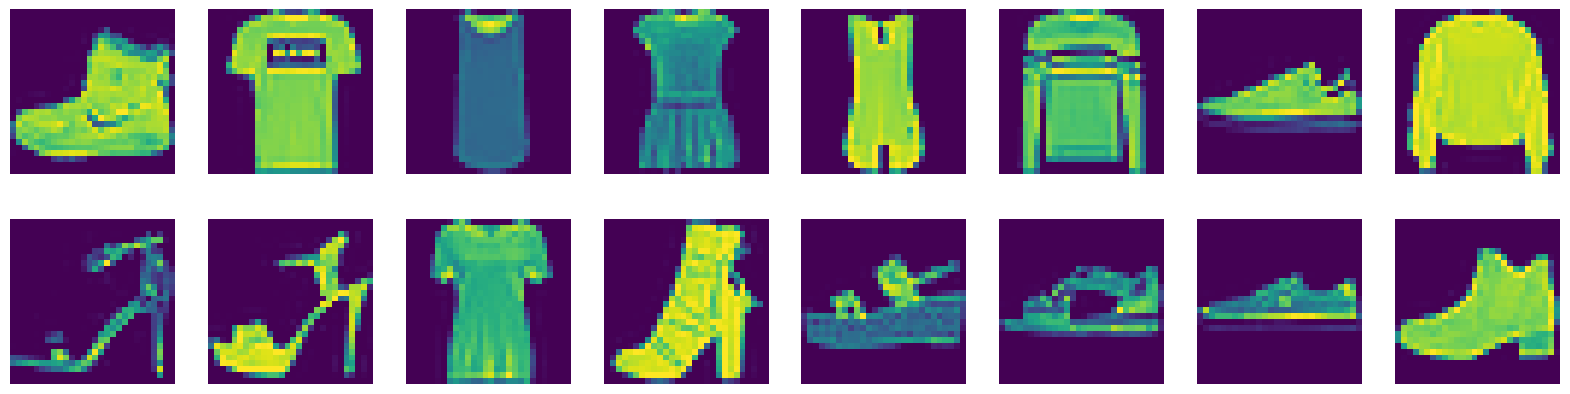

In [59]:
plt.figure(figsize = (20, 5))
row_number = 2
col_number = min(8, int(batch_size / row_number))

for i in range(row_number * col_number):
        ax = plt.subplot(row_number, col_number, i + 1)
        plt.imshow(dataset_train[i][0].view((28, 28)))
        plt.axis("off")

In [60]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.nz = latent_dim
        self.generator = nn.Sequential(
            nn.Linear(self.nz, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    
    def forward(self, x):
        return self.generator(x).view(
            -1, 
            channel_number, 
            image_height, 
            image_width
        )

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = channel_number * image_height * image_width
        self.discriminator = nn.Sequential(
            nn.Linear(self.n_input, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(-1, 784)
        return(self.discriminator(x))

In [61]:
generator = Generator(latent_dim = latnet_dimension).to(device)

print(generator)

total_params = sum(p.numel() for p in generator.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
    p.numel() for p in generator.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Generator(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=1024, out_features=784, bias=True)
    (9): Tanh()
  )
)
1,506,448 total parameters.
1,506,448 training parameters.


In [62]:
discriminator = Discriminator().to(device)
print(discriminator)

total_params = sum(p.numel() for p in discriminator.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
    p.numel() for p in discriminator.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Discriminator(
  (discriminator): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
533,505 total parameters.
533,505 training parameters.


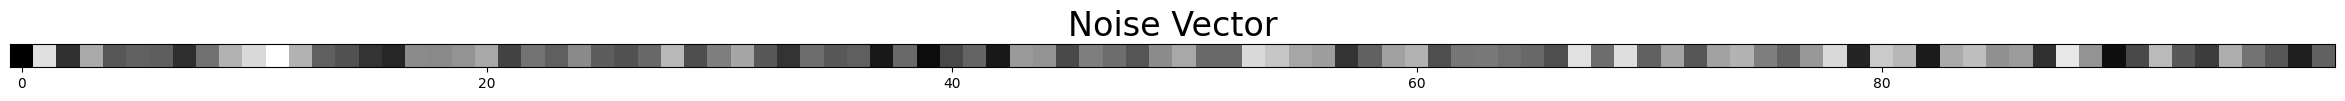

In [63]:
noise = torch.randn(1, latnet_dimension)

plt.figure(figsize = (30, 10))
plt.imshow(noise, cmap = 'gray')
plt.yticks([])
plt.title("Noise Vector", fontsize = 24)
plt.show()

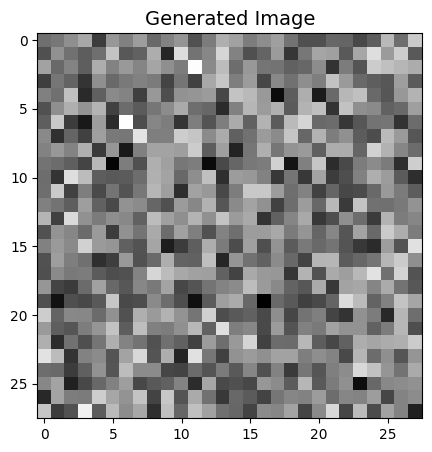

In [64]:
generated_image = generator(noise.to(device))

plt.figure(figsize = (5, 5))

generated_image = generated_image.detach().cpu().view(28, 28)

plt.imshow(np.squeeze(generated_image, -1) * 127.5, cmap = 'gray')
plt.title('Generated Image', fontsize = 14)
plt.show()

In [65]:
optimizer_generator = optim.Adam(
    generator.parameters(), 
    lr = generator_learning_rate,
    betas = (0.5, 0.999)
)

optimizer_discriminator = optim.Adam(
    discriminator.parameters(), 
    lr = discriminator_learning_rate,
    betas = (0.5, 0.999)
)

In [66]:
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
    
num_versions = len(os.listdir(checkpoint_path)) + 1
ckpt_version_dir = checkpoint_path + '/version_' + str(num_versions)

os.makedirs(ckpt_version_dir)

In [67]:
checkpoint_dir = checkpoint_path
generator_ckpt = os.path.join(ckpt_version_dir, 'generator'+'.pth')
discriminatr_ckpt = os.path.join(ckpt_version_dir, 'discriminator'+'.pth')

In [68]:
bce = nn.BCELoss()

def loss_func(y_true, y_pred):
    loss = bce(y_pred, y_true)
    return loss

In [69]:
def training_step(real_image):
    optimizer_generator.zero_grad()
    optimizer_discriminator.zero_grad()
    
    labels = torch.cat(
        (torch.ones(batch_size, 1),
         torch.zeros(batch_size, 1)
        ), dim = 0
    ).to(device)
    
    misleading_label = torch.ones(batch_size, 1).to(device)
    
    noise = torch.randn(
        batch_size,
        latnet_dimension
    ).to(device)

    fake_image = generator(noise)
    
    y_pred_real = discriminator(real_image)
    
    y_pred_fake = discriminator(fake_image)
    
    y_pred_D = torch.cat((y_pred_real, y_pred_fake), dim = 0)
    
    discriminator_loss = loss_func(labels, y_pred_D)
        
    discriminator_loss.backward()
    optimizer_discriminator.step()

    fake_image = generator(noise)
    
    y_pred_fake = discriminator(fake_image)

    generator_loss = loss_func(misleading_label, y_pred_fake)
    
    generator_loss.backward()
    optimizer_generator.step()
    
    return discriminator_loss, generator_loss

In [70]:
fixed_noise = torch.randn(int(batch_size / 2), latnet_dimension, )

def plot_image(model):
    model.eval()
    with torch.no_grad():
        image = model(fixed_noise.to(device))
        image = image.detach().cpu().view((image.shape[0], 28, 28))

    plt.figure(figsize = (20, 4))

    nrow = 2
    ncol = int(image.shape[0] / nrow)
    
    for i, image in enumerate(image):
        col = int(batch_size / 2)
        plt.subplot(nrow, ncol, i+1)
        plt.imshow(np.squeeze(image, -1) * 127.5, cmap = 'gray')
        plt.axis('off')
        
    plt.show()

In [71]:
generator_loss = []
discriminator_loss = []

def start_training(dataloader, epochs):
    for epoch in range(epochs):
        generator.train()
        discriminator.train()
        start = time.time()
        i = 0
        D_loss_list, G_loss_list = [], []
        
        for _, data in tqdm(enumerate(dataloader), total = int(len(dataloader))):
            
            image_batch, _ = data
            image_batch = image_batch.to(device)
            
            i += 1
            
            D_loss, G_loss = training_step(image_batch)
            
            D_loss_list.append(D_loss)
            G_loss_list.append(G_loss)
            
        if (epoch + 1) % 5 == 0:
            torch.save(generator, generator_ckpt)
            torch.save(discriminator, discriminatr_ckpt)
            
        epoch_discriminator_loss = sum(D_loss_list)/len(D_loss_list)
        epoch_generator_loss = sum(G_loss_list)/len(G_loss_list)

        discriminator_loss.append(epoch_discriminator_loss.detach().cpu())
        generator_loss.append(epoch_generator_loss.detach().cpu())
        
        print('\n')
        print(f"Time for epoch {epoch + 1} is {time.time()-start} sec")
        print(f"Generator loss: {epoch_generator_loss:.3f}, Discriminator loss: {epoch_discriminator_loss:.3f}")

        plot_image(generator)     

100%|██████████| 1875/1875 [00:12<00:00, 155.27it/s]



Time for epoch 1 is 12.16977334022522 sec
Generator loss: 2.170, Discriminator loss: 0.398


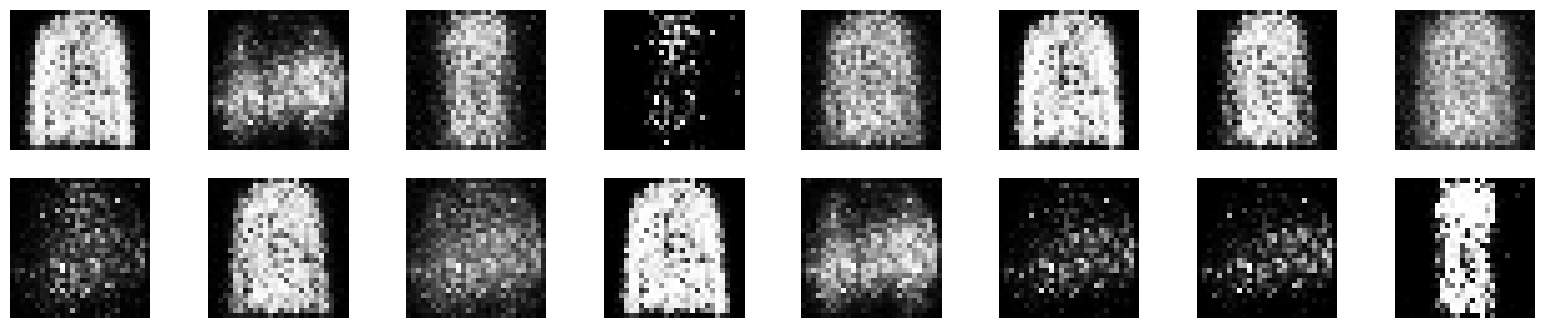

100%|██████████| 1875/1875 [00:11<00:00, 163.92it/s]




Time for epoch 2 is 11.555468797683716 sec
Generator loss: 1.827, Discriminator loss: 0.459


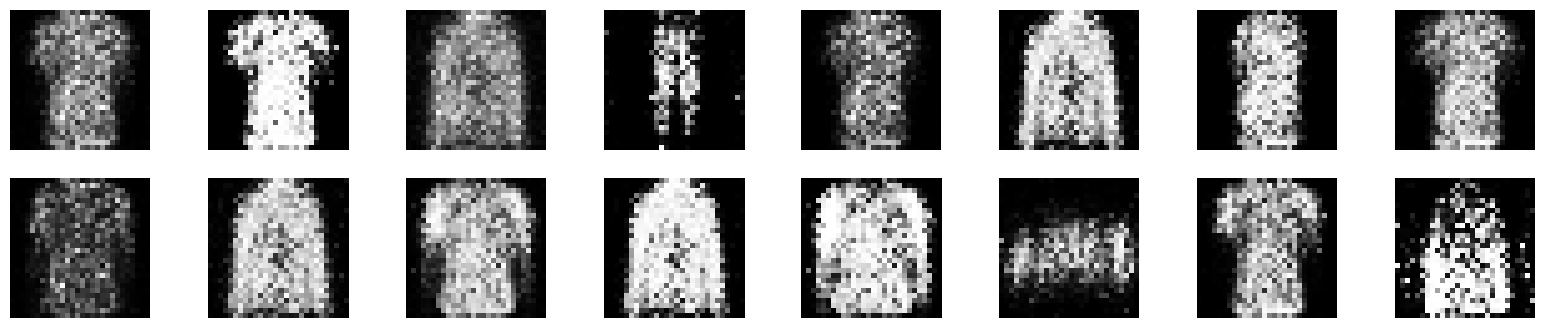

100%|██████████| 1875/1875 [00:11<00:00, 159.55it/s]




Time for epoch 3 is 11.861184358596802 sec
Generator loss: 1.423, Discriminator loss: 0.503


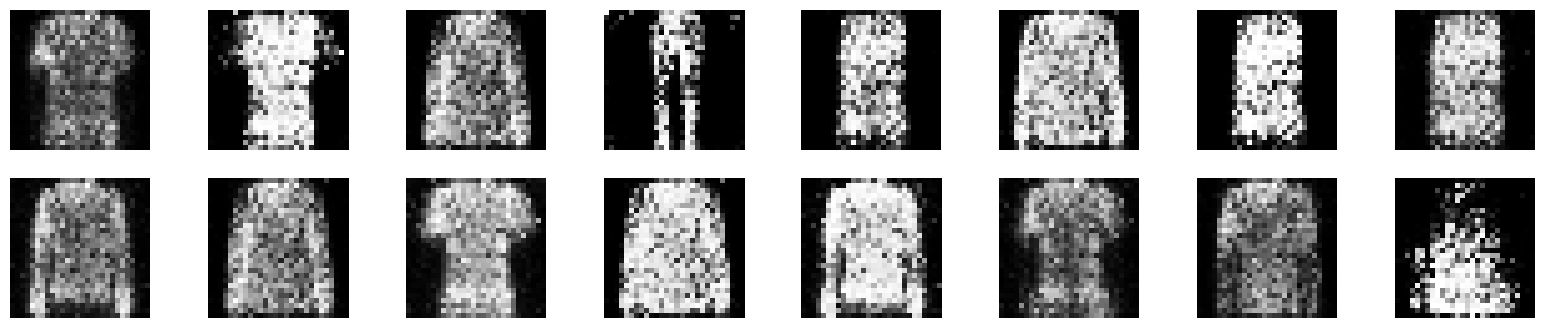

100%|██████████| 1875/1875 [00:11<00:00, 162.75it/s]




Time for epoch 4 is 11.627836465835571 sec
Generator loss: 1.313, Discriminator loss: 0.505


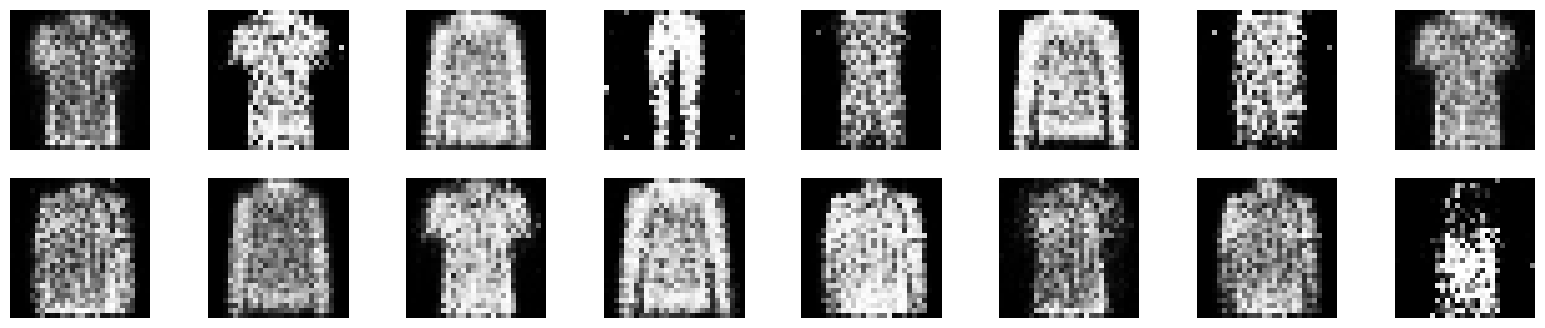

100%|██████████| 1875/1875 [00:11<00:00, 160.29it/s]




Time for epoch 5 is 11.82335638999939 sec
Generator loss: 1.244, Discriminator loss: 0.514


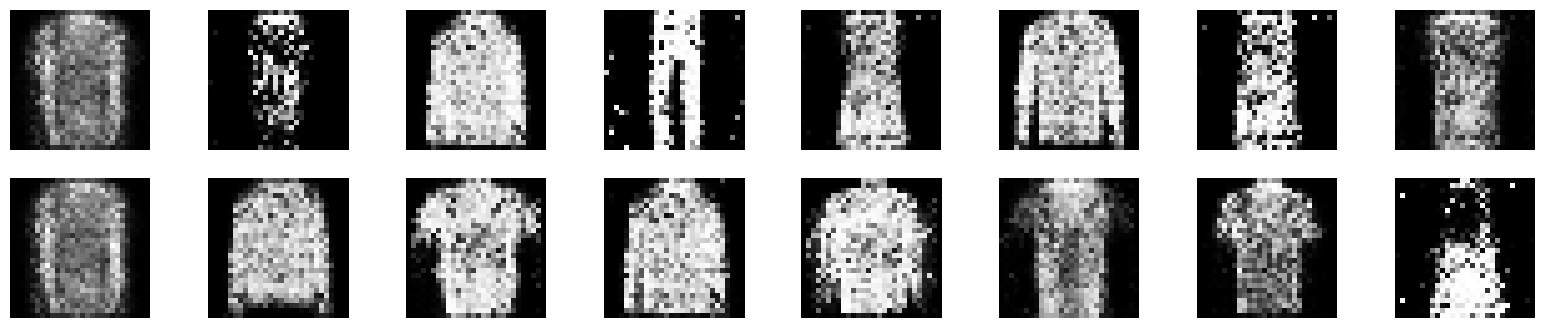

100%|██████████| 1875/1875 [00:11<00:00, 161.19it/s]




Time for epoch 6 is 11.74056887626648 sec
Generator loss: 1.235, Discriminator loss: 0.515


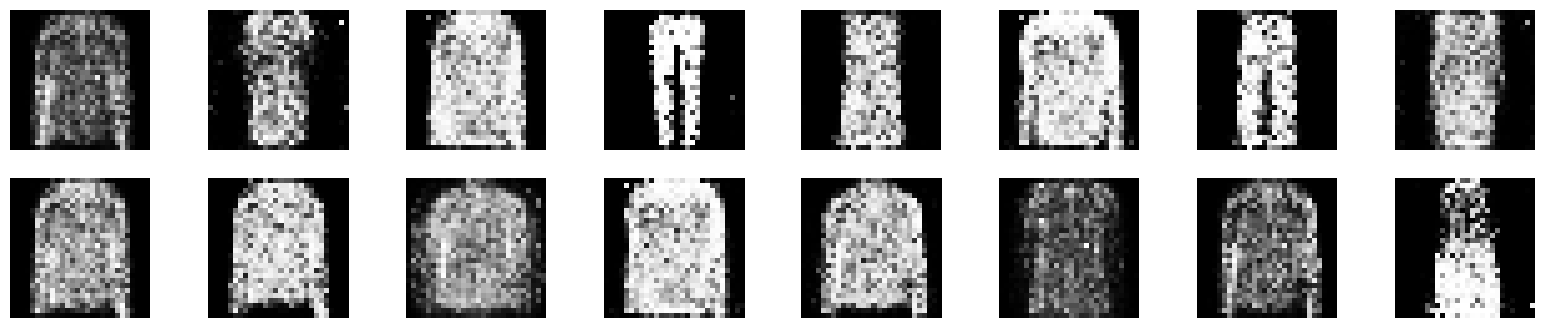

100%|██████████| 1875/1875 [00:12<00:00, 148.90it/s]




Time for epoch 7 is 12.701565265655518 sec
Generator loss: 1.189, Discriminator loss: 0.520


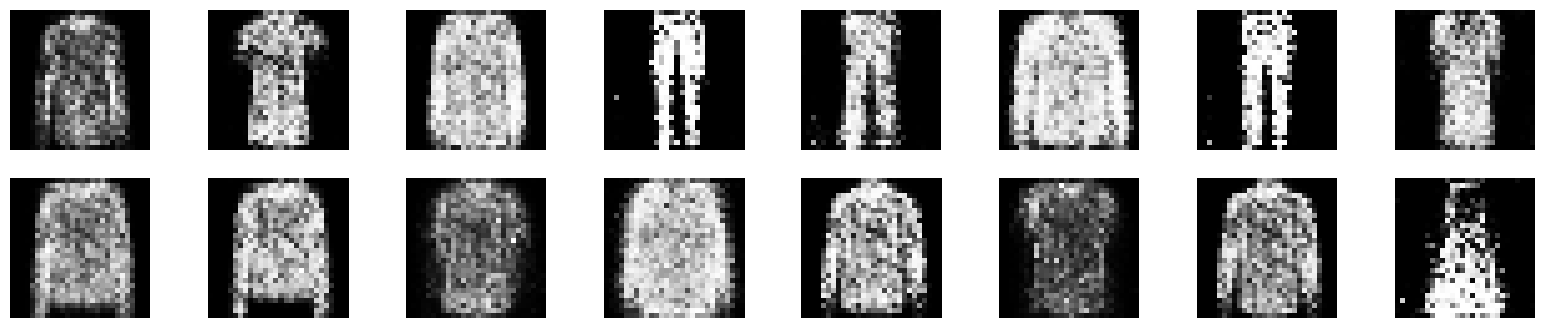

100%|██████████| 1875/1875 [00:13<00:00, 134.23it/s]




Time for epoch 8 is 14.071451902389526 sec
Generator loss: 1.147, Discriminator loss: 0.530


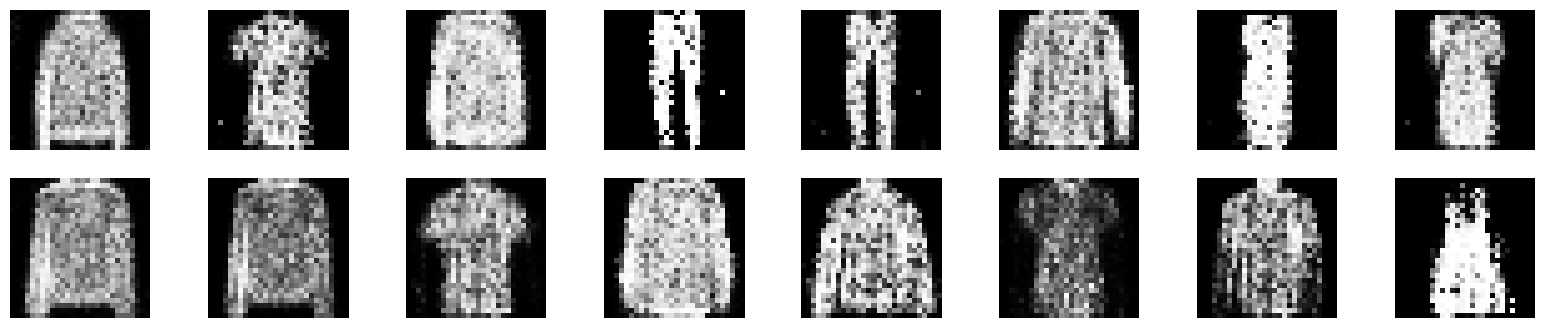

100%|██████████| 1875/1875 [00:11<00:00, 156.93it/s]



Time for epoch 9 is 12.048840999603271 sec
Generator loss: 1.109, Discriminator loss: 0.535


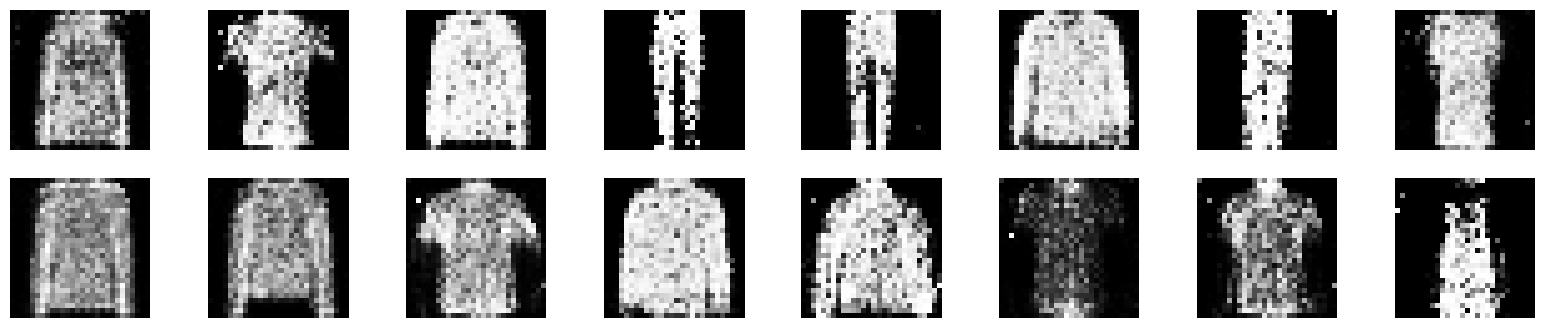

100%|██████████| 1875/1875 [00:11<00:00, 160.88it/s]




Time for epoch 10 is 11.778750896453857 sec
Generator loss: 1.096, Discriminator loss: 0.536


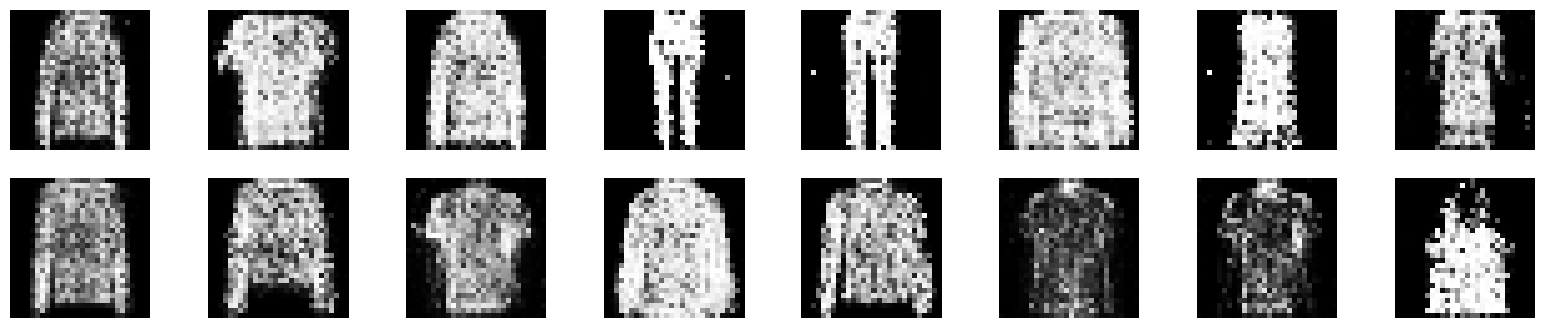

100%|██████████| 1875/1875 [00:12<00:00, 151.08it/s]




Time for epoch 11 is 12.511039733886719 sec
Generator loss: 1.077, Discriminator loss: 0.540


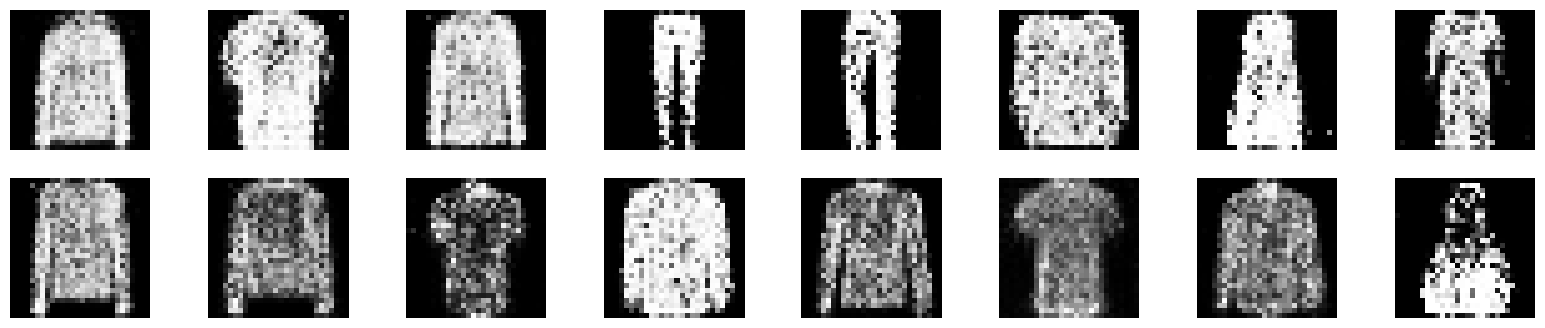

100%|██████████| 1875/1875 [00:11<00:00, 161.28it/s]




Time for epoch 12 is 11.727603197097778 sec
Generator loss: 1.067, Discriminator loss: 0.541


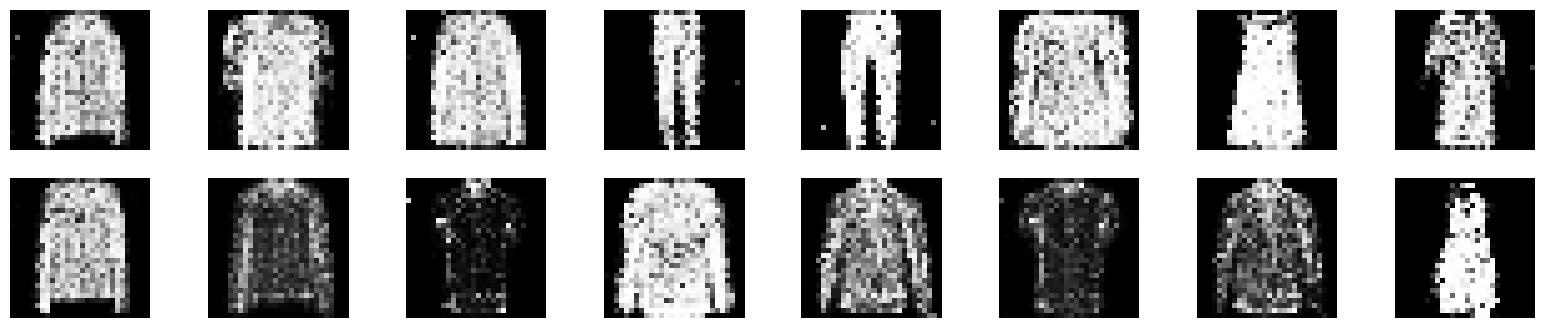

100%|██████████| 1875/1875 [00:11<00:00, 160.63it/s]




Time for epoch 13 is 11.77606987953186 sec
Generator loss: 1.075, Discriminator loss: 0.540


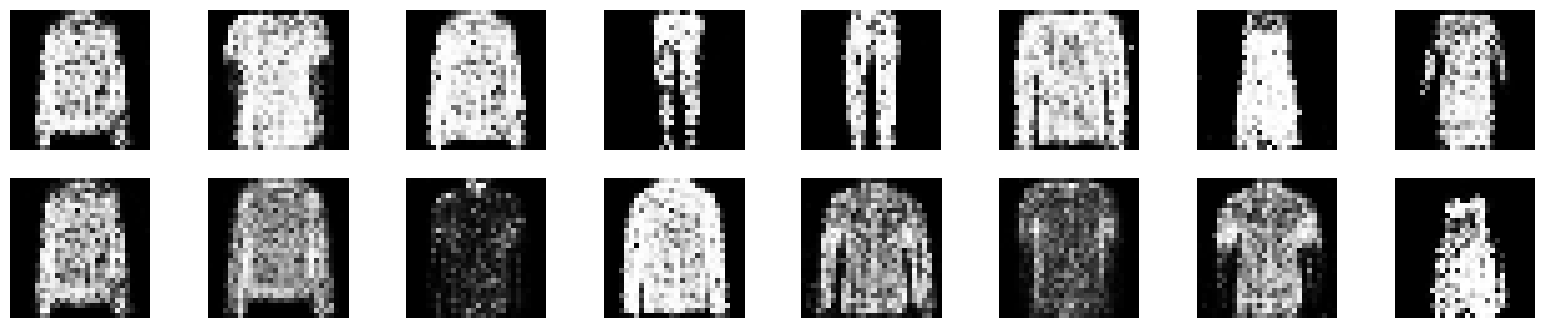

100%|██████████| 1875/1875 [00:11<00:00, 161.16it/s]




Time for epoch 14 is 11.738527774810791 sec
Generator loss: 1.059, Discriminator loss: 0.545


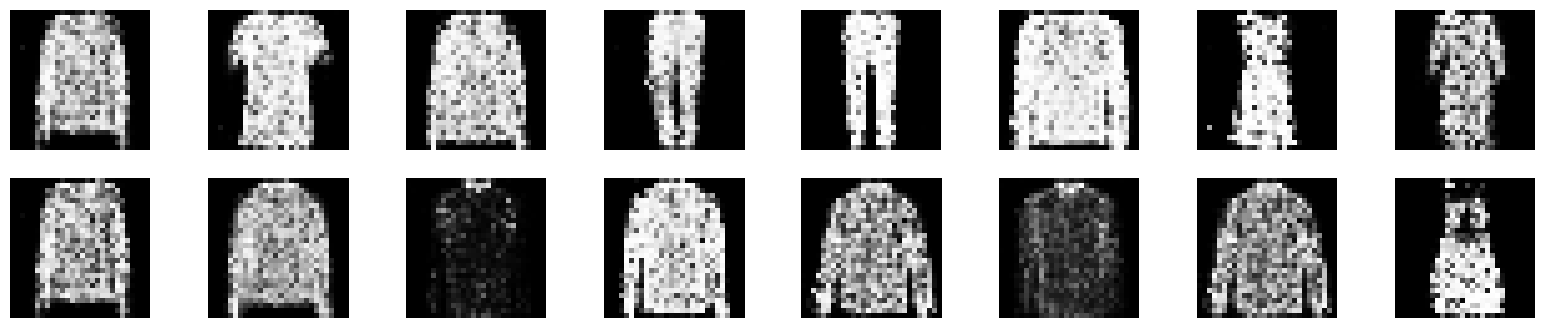

100%|██████████| 1875/1875 [00:12<00:00, 147.73it/s]




Time for epoch 15 is 12.809052228927612 sec
Generator loss: 1.052, Discriminator loss: 0.545


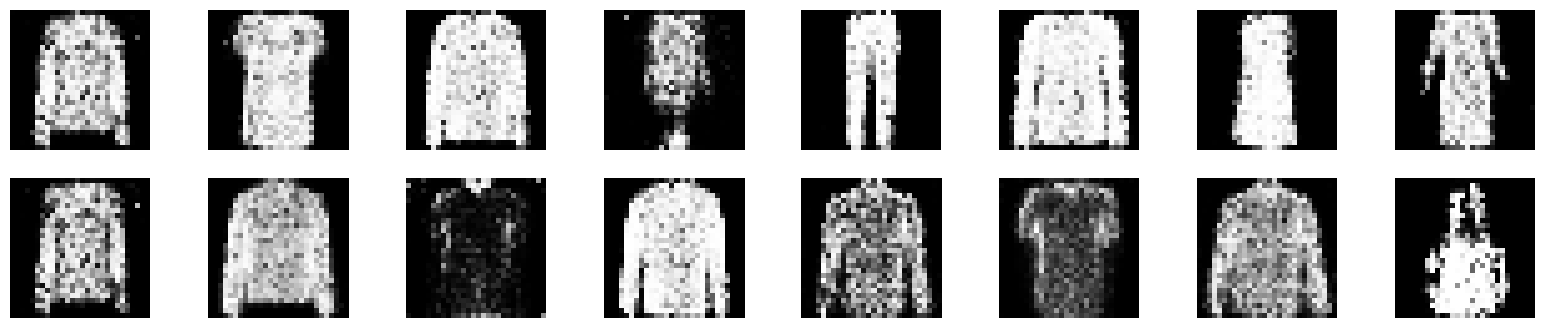

100%|██████████| 1875/1875 [00:11<00:00, 156.45it/s]




Time for epoch 16 is 12.085058689117432 sec
Generator loss: 1.041, Discriminator loss: 0.544


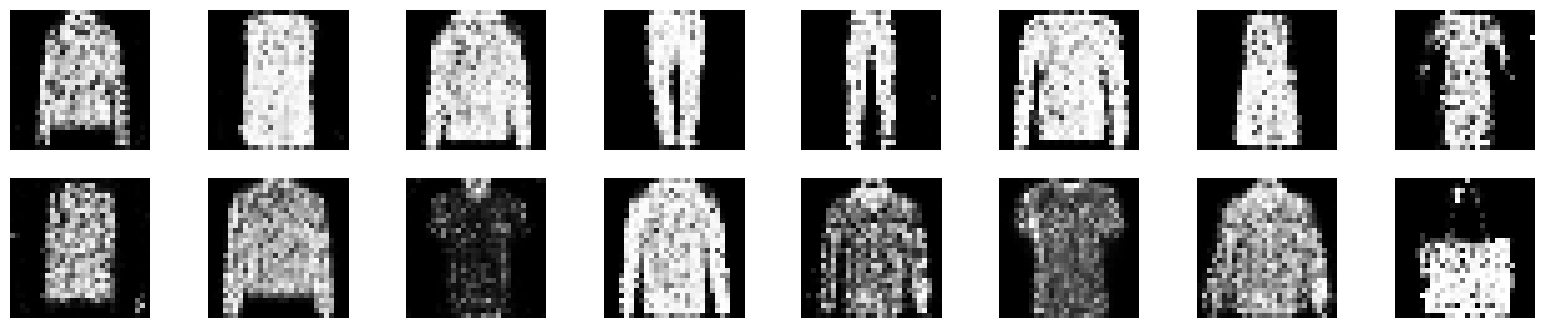

100%|██████████| 1875/1875 [00:11<00:00, 156.73it/s]




Time for epoch 17 is 12.06807279586792 sec
Generator loss: 1.039, Discriminator loss: 0.544


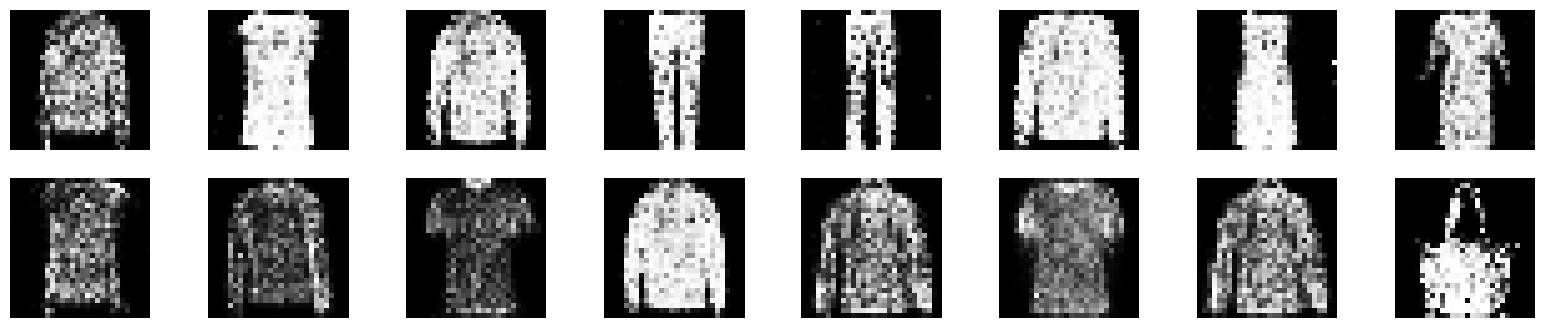

100%|██████████| 1875/1875 [00:12<00:00, 155.03it/s]




Time for epoch 18 is 12.20149302482605 sec
Generator loss: 1.038, Discriminator loss: 0.546


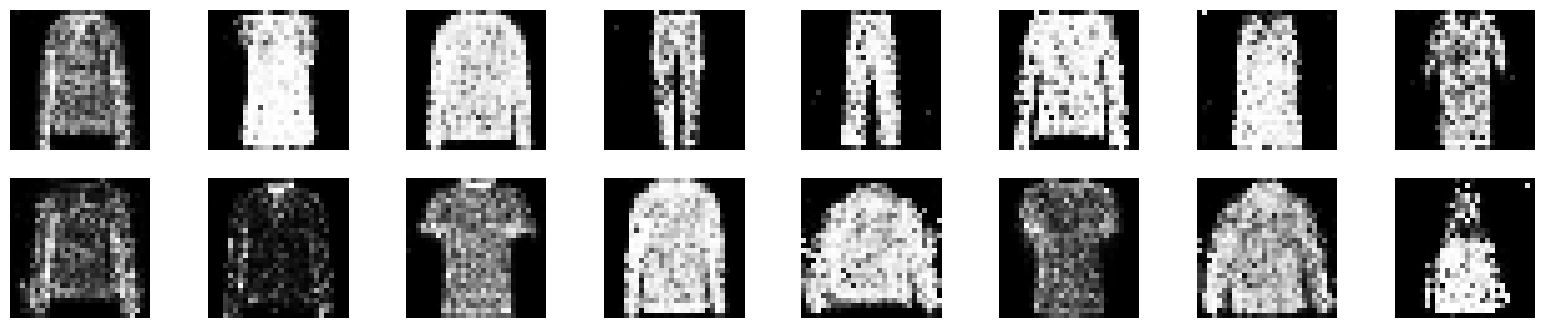

100%|██████████| 1875/1875 [00:12<00:00, 147.01it/s]




Time for epoch 19 is 12.859333992004395 sec
Generator loss: 1.032, Discriminator loss: 0.547


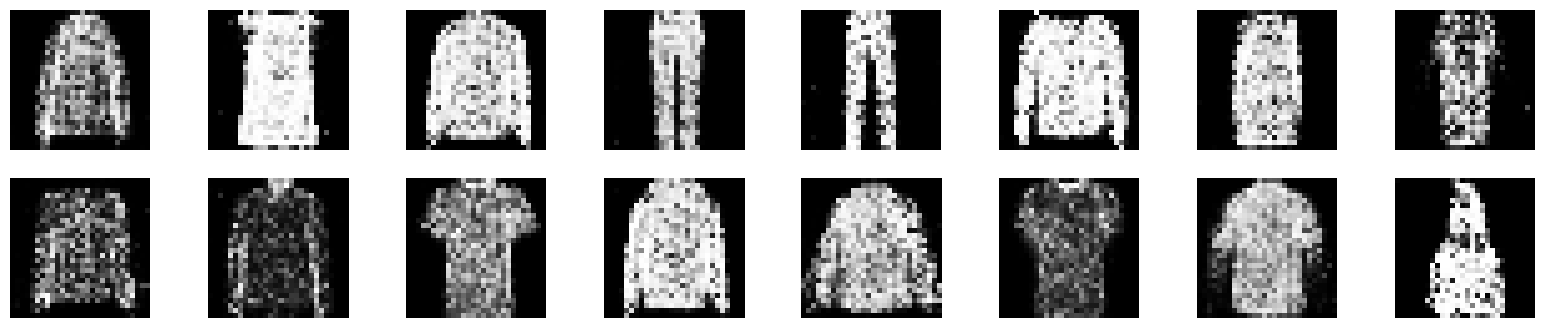

100%|██████████| 1875/1875 [00:13<00:00, 138.18it/s]




Time for epoch 20 is 13.681981325149536 sec
Generator loss: 1.039, Discriminator loss: 0.545


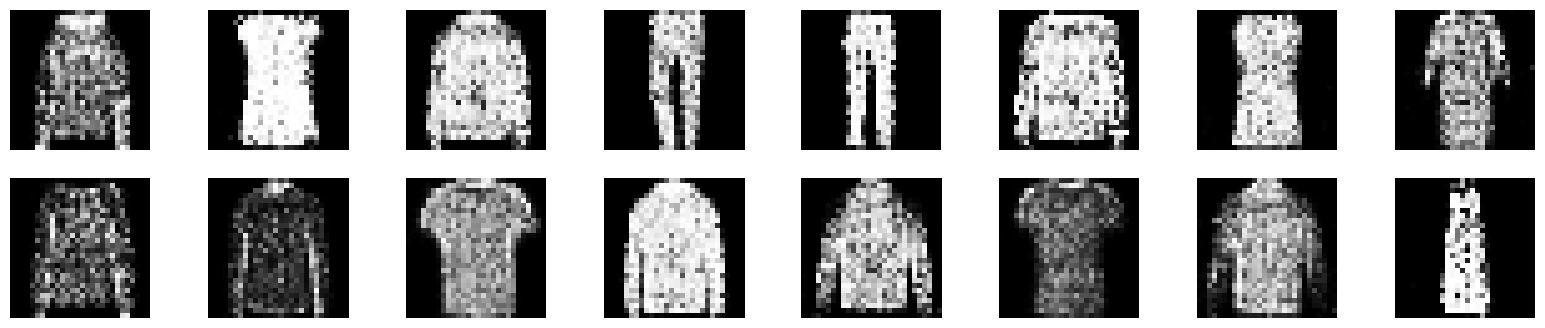

100%|██████████| 1875/1875 [00:12<00:00, 149.67it/s]




Time for epoch 21 is 12.637831211090088 sec
Generator loss: 1.031, Discriminator loss: 0.546


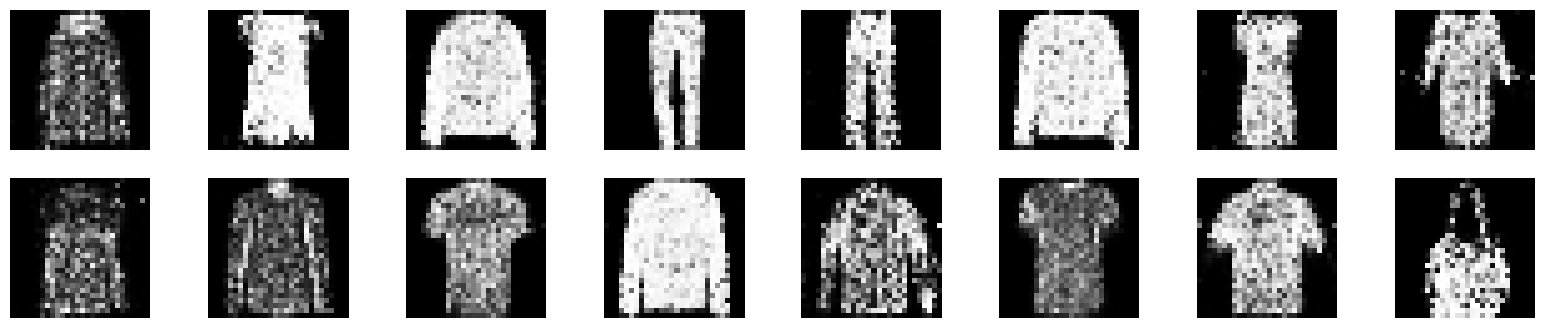

100%|██████████| 1875/1875 [00:13<00:00, 139.36it/s]




Time for epoch 22 is 13.564558506011963 sec
Generator loss: 1.030, Discriminator loss: 0.545


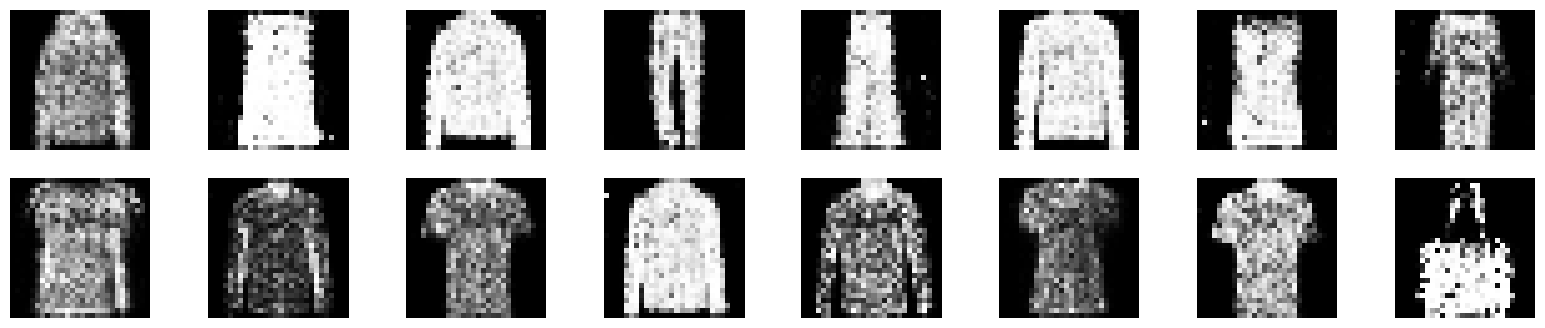

100%|██████████| 1875/1875 [00:12<00:00, 153.33it/s]




Time for epoch 23 is 12.332853078842163 sec
Generator loss: 1.028, Discriminator loss: 0.546


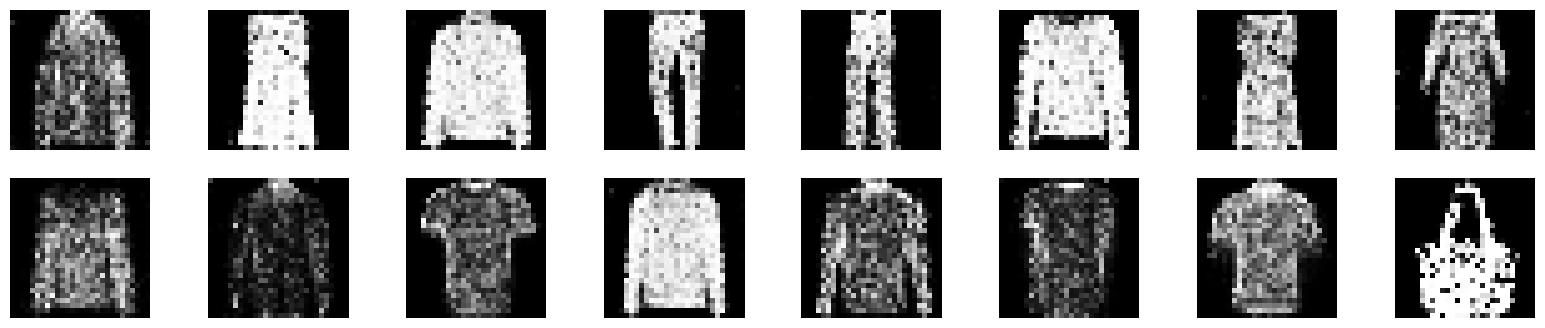

100%|██████████| 1875/1875 [00:12<00:00, 153.83it/s]




Time for epoch 24 is 12.287944793701172 sec
Generator loss: 1.028, Discriminator loss: 0.546


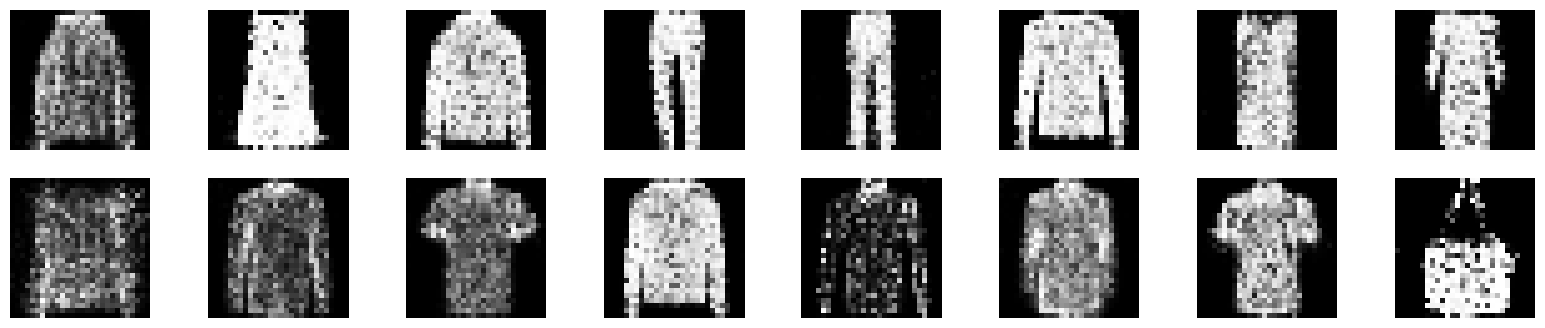

100%|██████████| 1875/1875 [00:14<00:00, 133.10it/s]




Time for epoch 25 is 14.223535537719727 sec
Generator loss: 1.028, Discriminator loss: 0.546


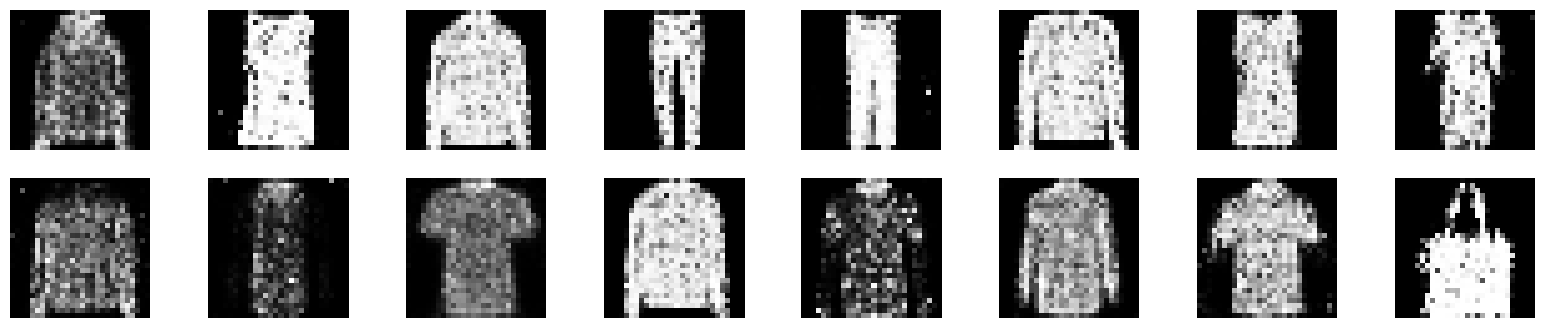

100%|██████████| 1875/1875 [00:15<00:00, 122.67it/s]




Time for epoch 26 is 15.40760612487793 sec
Generator loss: 1.030, Discriminator loss: 0.545


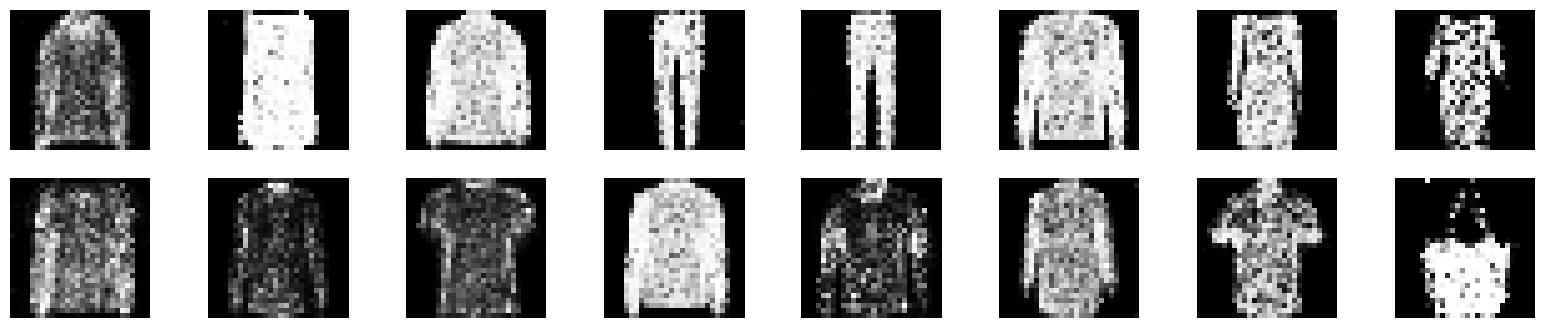

100%|██████████| 1875/1875 [00:16<00:00, 115.09it/s]




Time for epoch 27 is 16.415987014770508 sec
Generator loss: 1.031, Discriminator loss: 0.543


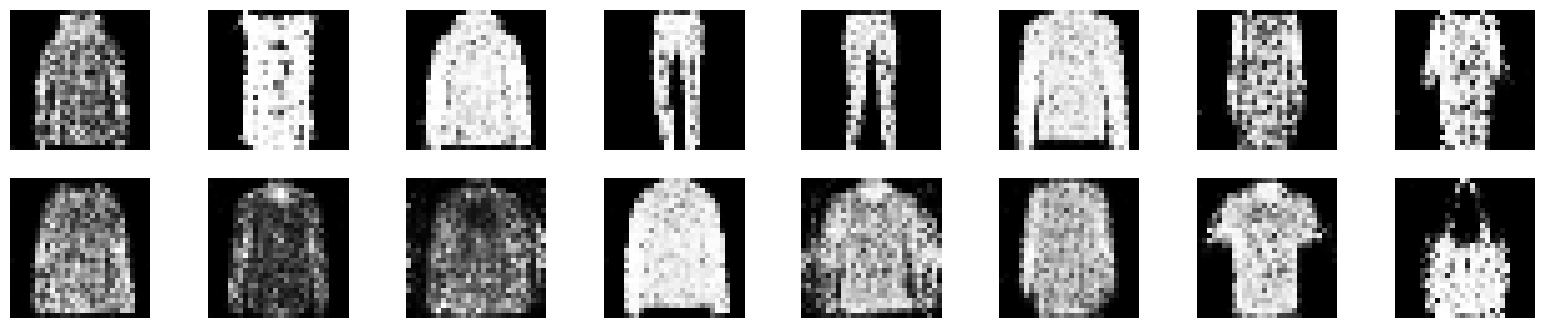

100%|██████████| 1875/1875 [00:14<00:00, 131.46it/s]




Time for epoch 28 is 14.378510236740112 sec
Generator loss: 1.028, Discriminator loss: 0.544


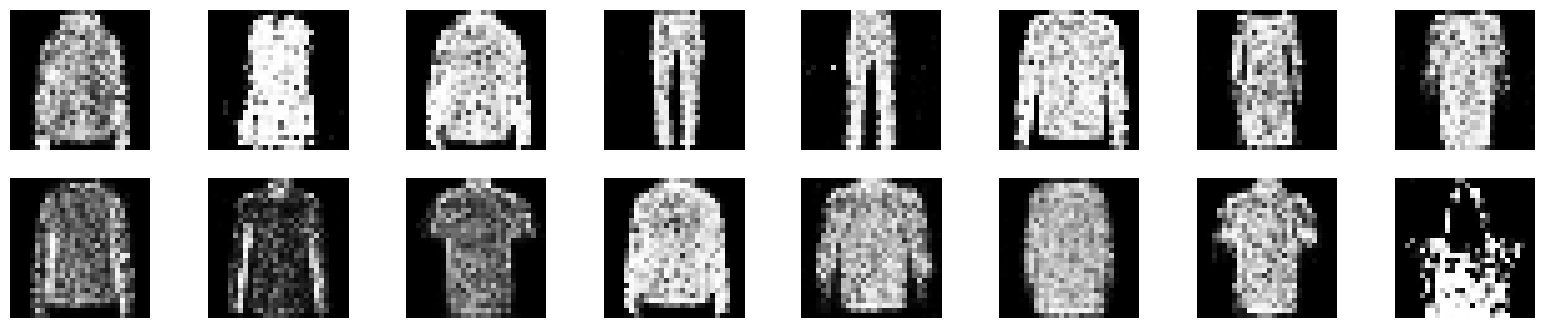

100%|██████████| 1875/1875 [00:15<00:00, 123.62it/s]




Time for epoch 29 is 15.29567265510559 sec
Generator loss: 1.027, Discriminator loss: 0.545


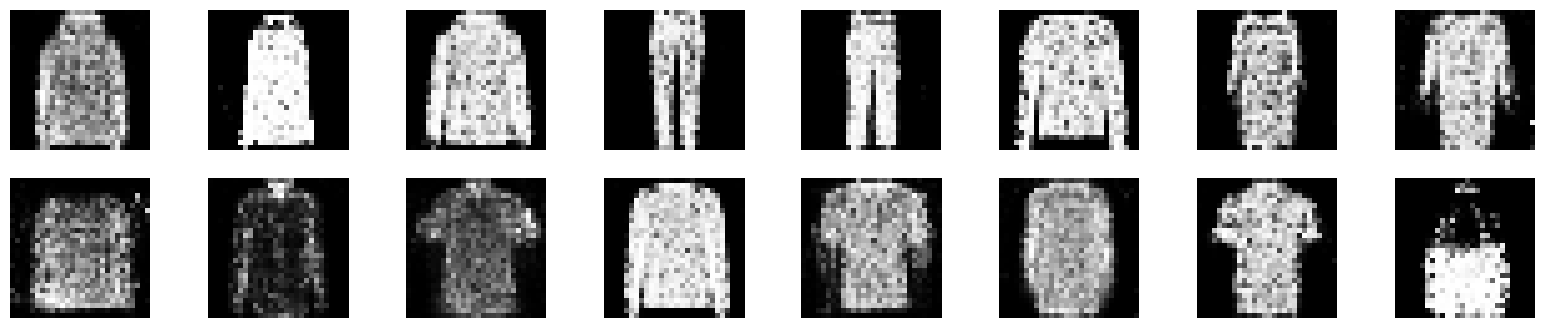

100%|██████████| 1875/1875 [00:14<00:00, 126.45it/s]




Time for epoch 30 is 14.973423719406128 sec
Generator loss: 1.024, Discriminator loss: 0.547


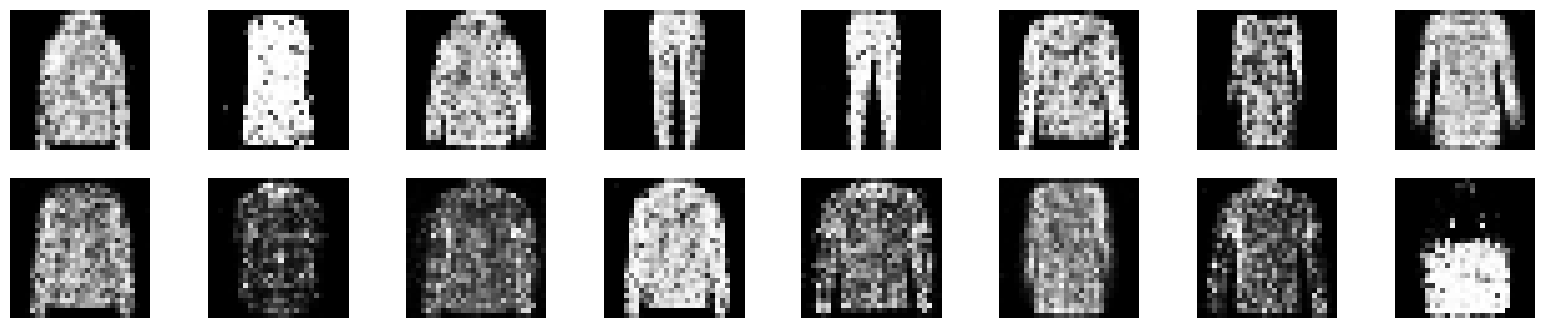

100%|██████████| 1875/1875 [00:17<00:00, 105.43it/s]




Time for epoch 31 is 17.9573974609375 sec
Generator loss: 1.025, Discriminator loss: 0.546


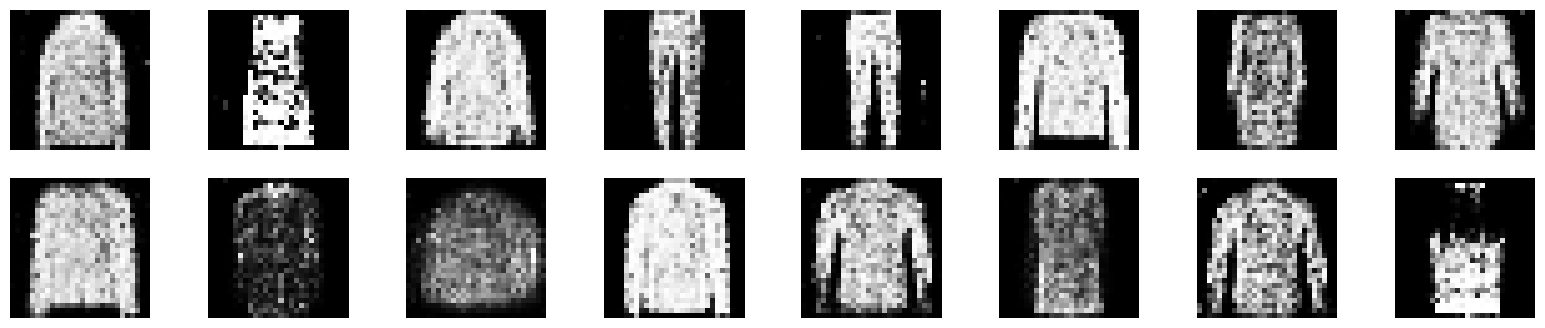

100%|██████████| 1875/1875 [00:16<00:00, 112.47it/s]




Time for epoch 32 is 16.804907083511353 sec
Generator loss: 1.025, Discriminator loss: 0.545


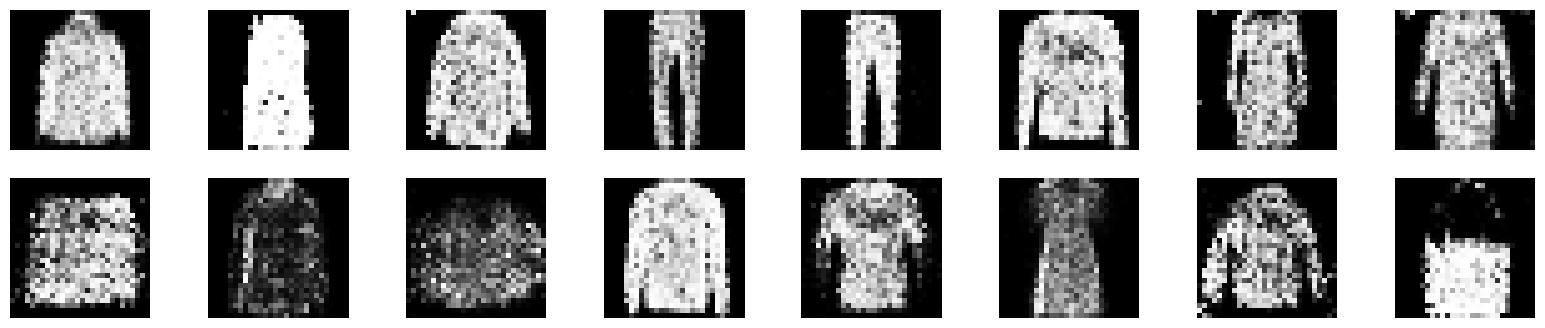

100%|██████████| 1875/1875 [00:13<00:00, 137.00it/s]




Time for epoch 33 is 13.808891296386719 sec
Generator loss: 1.025, Discriminator loss: 0.546


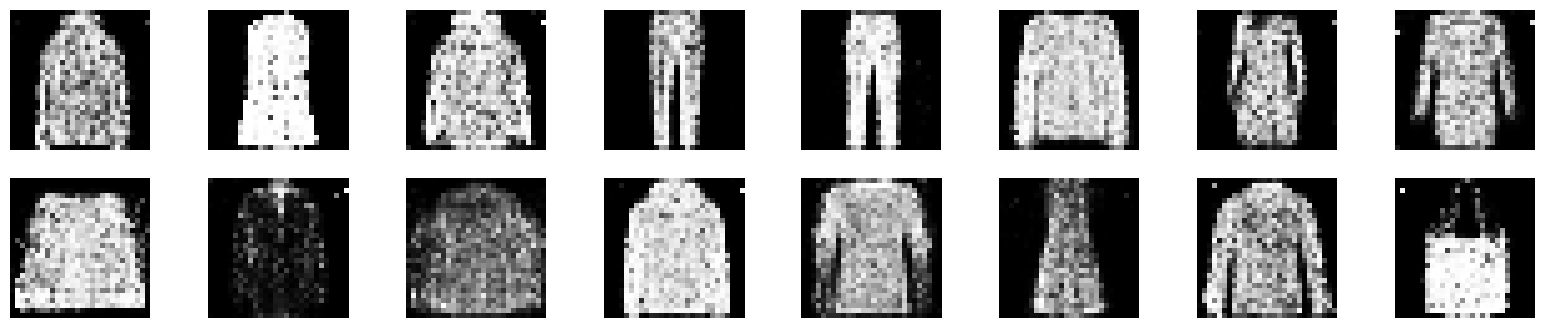

100%|██████████| 1875/1875 [00:14<00:00, 131.17it/s]




Time for epoch 34 is 14.41451358795166 sec
Generator loss: 1.026, Discriminator loss: 0.544


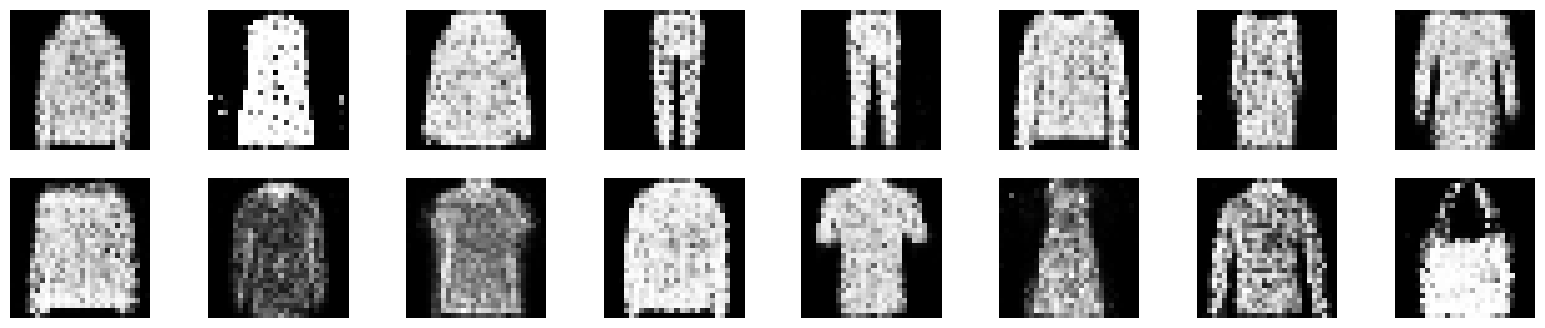

100%|██████████| 1875/1875 [00:14<00:00, 129.74it/s]




Time for epoch 35 is 14.58846926689148 sec
Generator loss: 1.026, Discriminator loss: 0.543


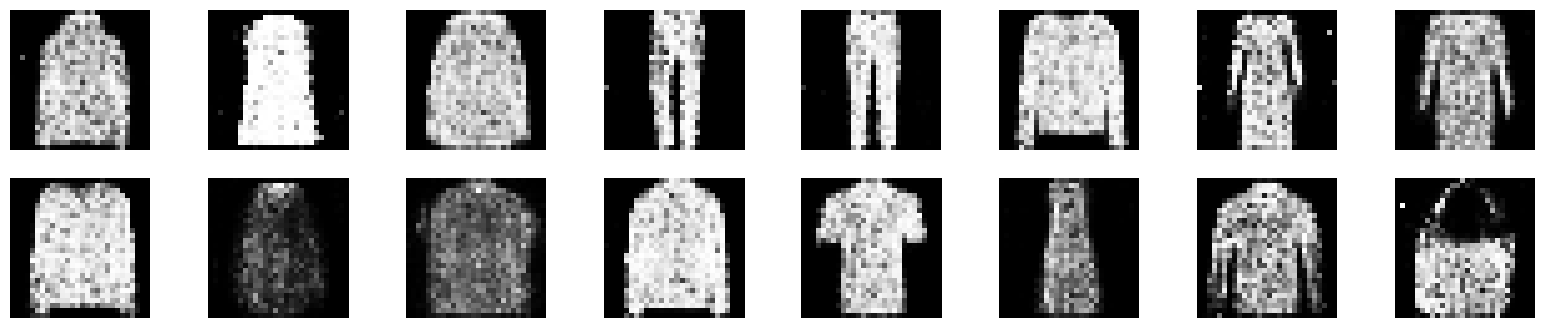

100%|██████████| 1875/1875 [00:14<00:00, 128.68it/s]




Time for epoch 36 is 14.690027236938477 sec
Generator loss: 1.028, Discriminator loss: 0.543


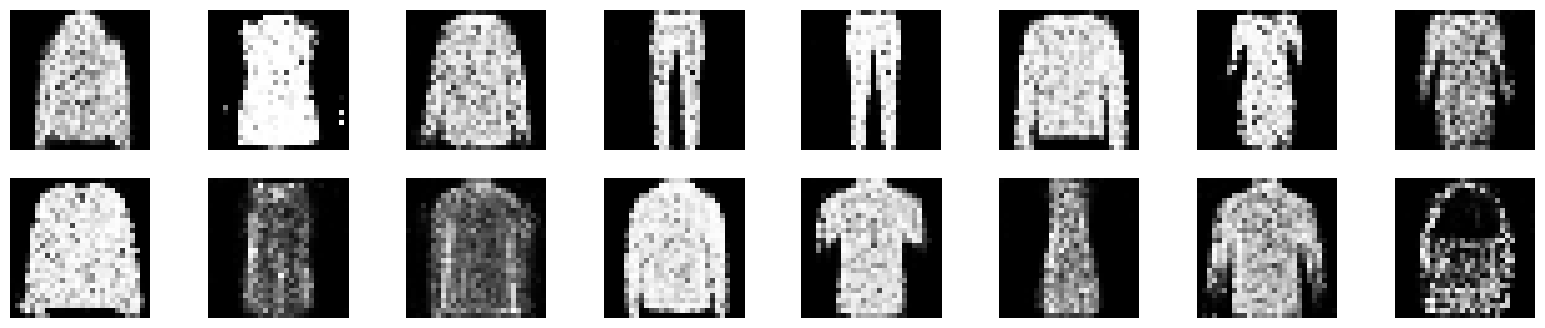

100%|██████████| 1875/1875 [00:14<00:00, 131.47it/s]




Time for epoch 37 is 14.388429641723633 sec
Generator loss: 1.031, Discriminator loss: 0.541


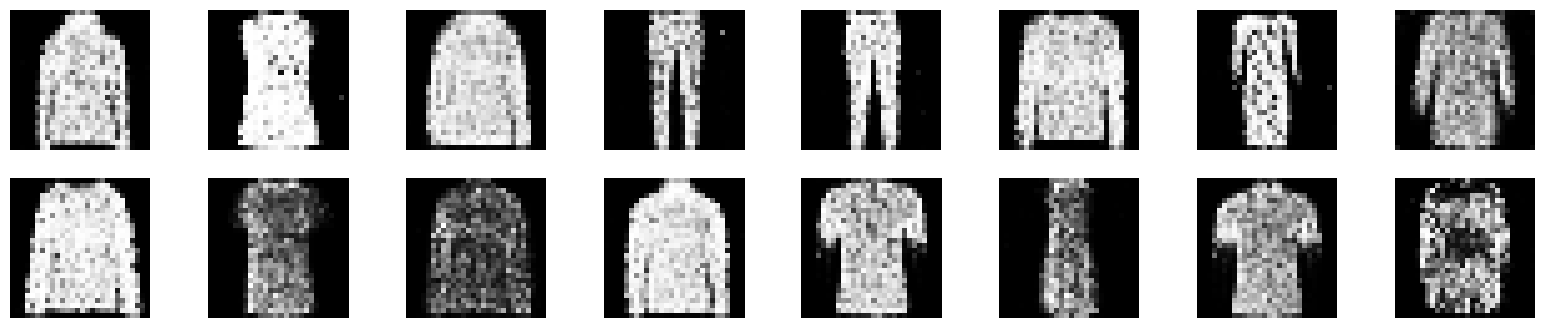

100%|██████████| 1875/1875 [00:13<00:00, 134.02it/s]




Time for epoch 38 is 14.116127490997314 sec
Generator loss: 1.030, Discriminator loss: 0.542


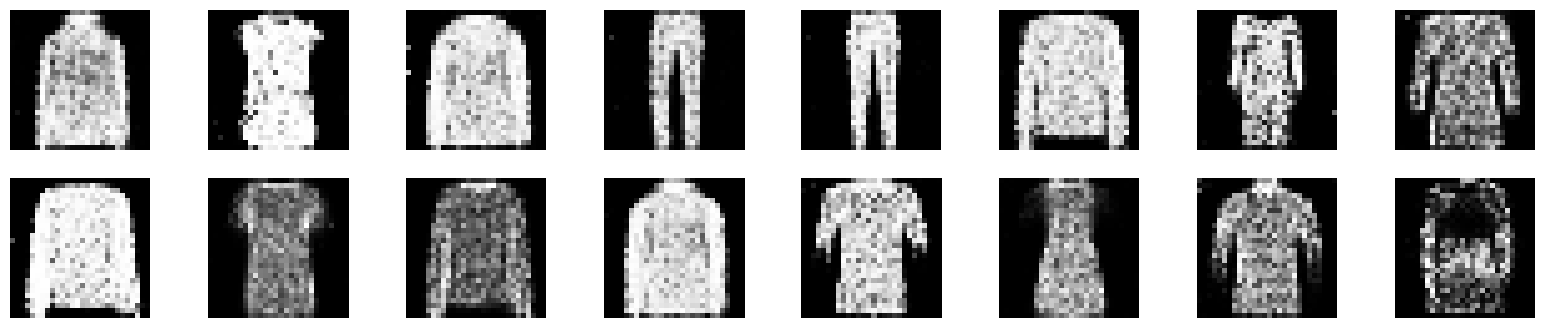

100%|██████████| 1875/1875 [00:14<00:00, 125.03it/s]




Time for epoch 39 is 15.125374794006348 sec
Generator loss: 1.027, Discriminator loss: 0.544


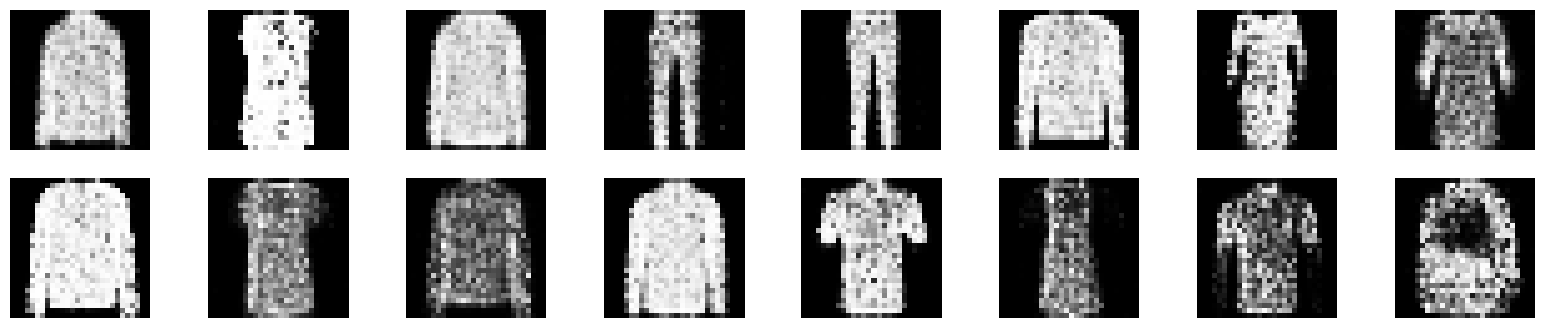

100%|██████████| 1875/1875 [00:15<00:00, 123.58it/s]




Time for epoch 40 is 15.333996772766113 sec
Generator loss: 1.033, Discriminator loss: 0.541


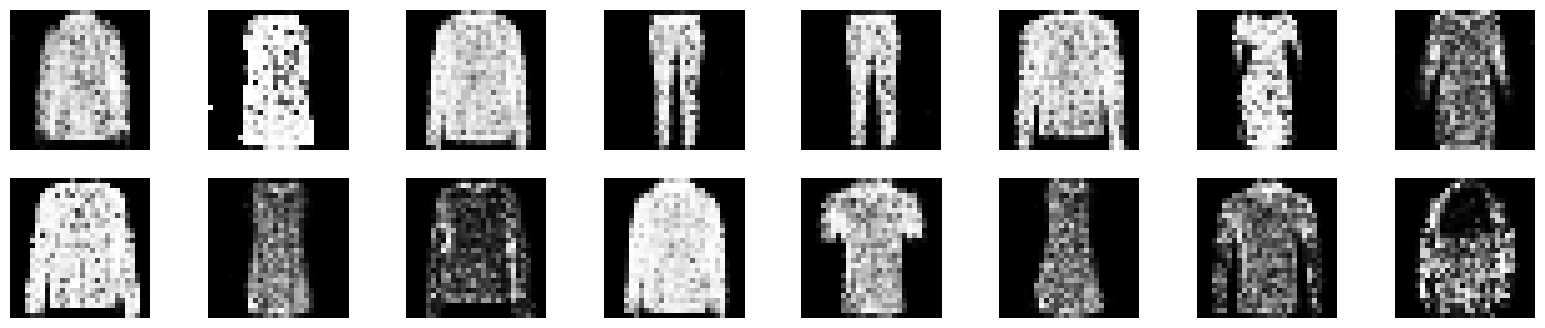

100%|██████████| 1875/1875 [00:15<00:00, 123.04it/s]




Time for epoch 41 is 15.385816097259521 sec
Generator loss: 1.031, Discriminator loss: 0.542


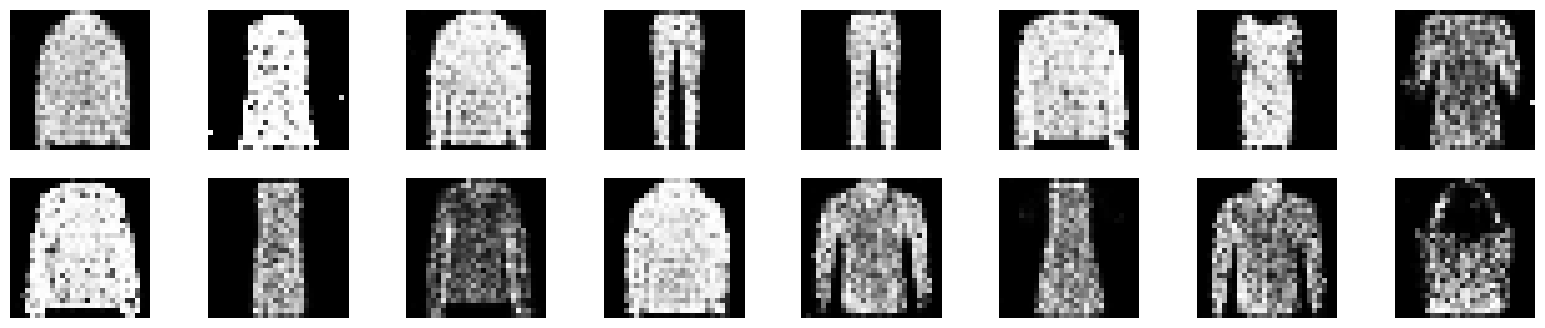

100%|██████████| 1875/1875 [00:13<00:00, 138.69it/s]




Time for epoch 42 is 13.639324188232422 sec
Generator loss: 1.035, Discriminator loss: 0.539


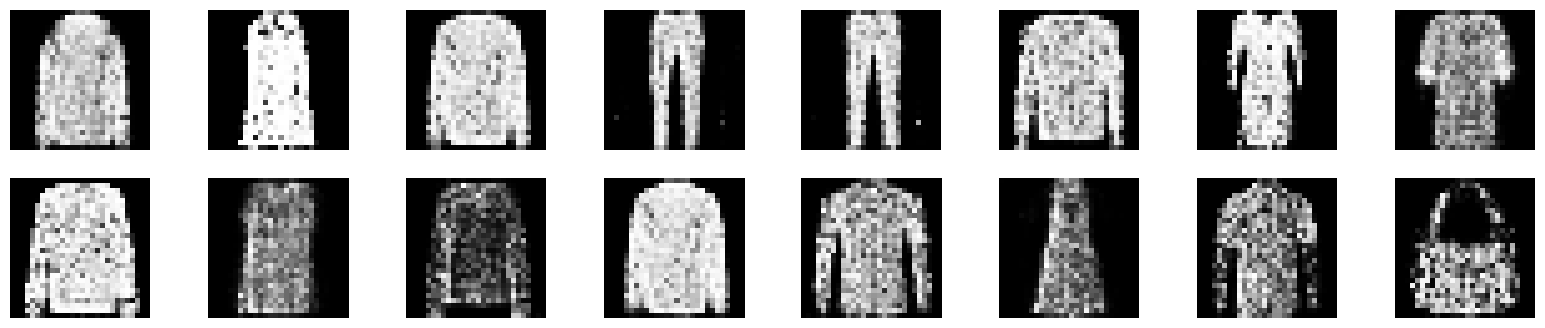

100%|██████████| 1875/1875 [00:12<00:00, 149.14it/s]




Time for epoch 43 is 12.67849326133728 sec
Generator loss: 1.030, Discriminator loss: 0.542


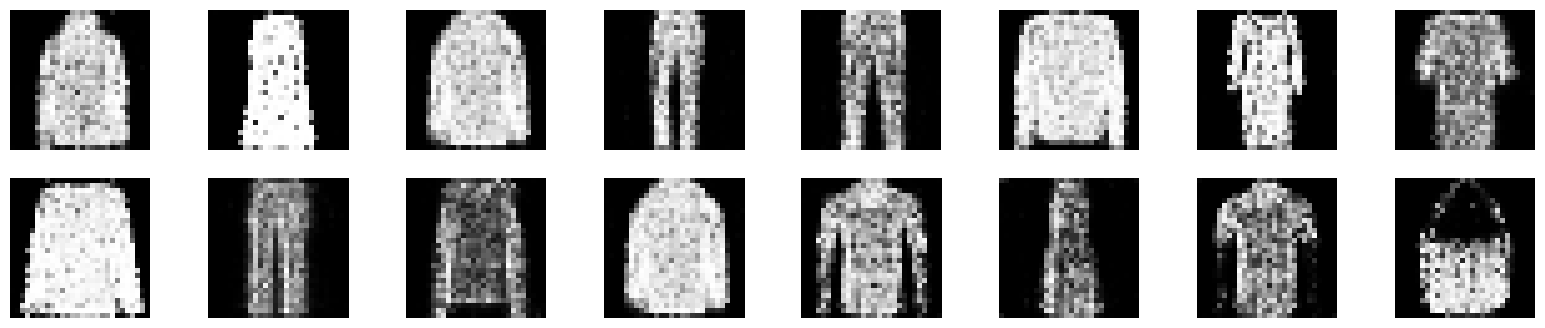

100%|██████████| 1875/1875 [00:13<00:00, 140.11it/s]




Time for epoch 44 is 13.4924795627594 sec
Generator loss: 1.031, Discriminator loss: 0.542


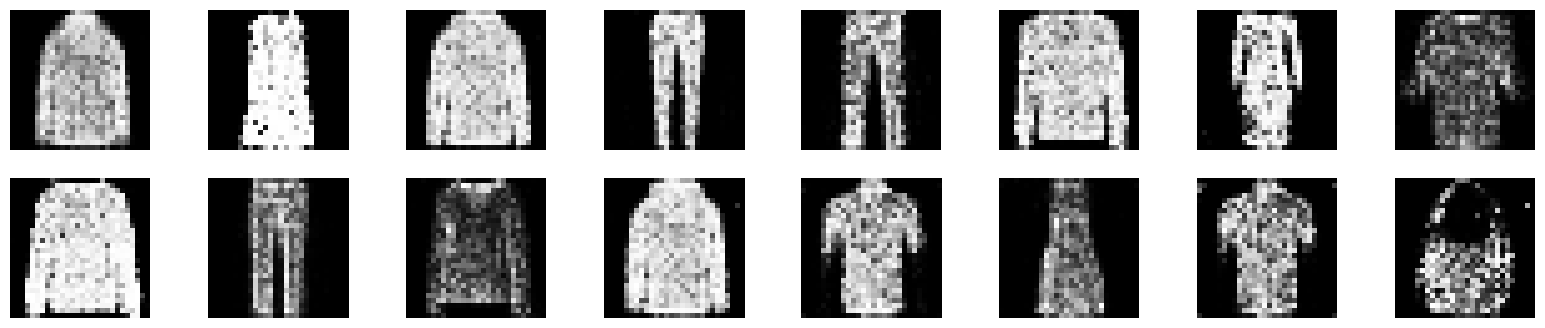

100%|██████████| 1875/1875 [00:13<00:00, 135.92it/s]




Time for epoch 45 is 13.938745498657227 sec
Generator loss: 1.031, Discriminator loss: 0.542


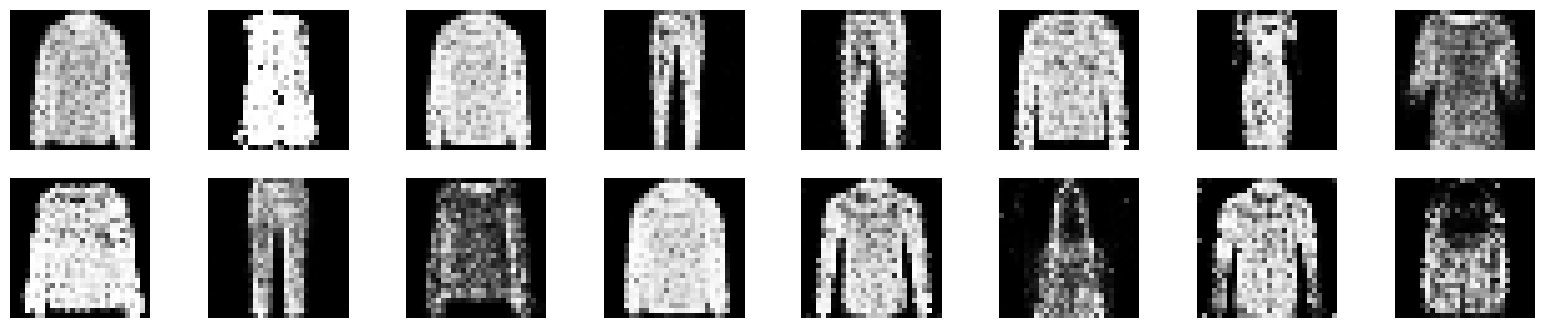

100%|██████████| 1875/1875 [00:20<00:00, 90.93it/s] 




Time for epoch 46 is 20.78978395462036 sec
Generator loss: 1.037, Discriminator loss: 0.538


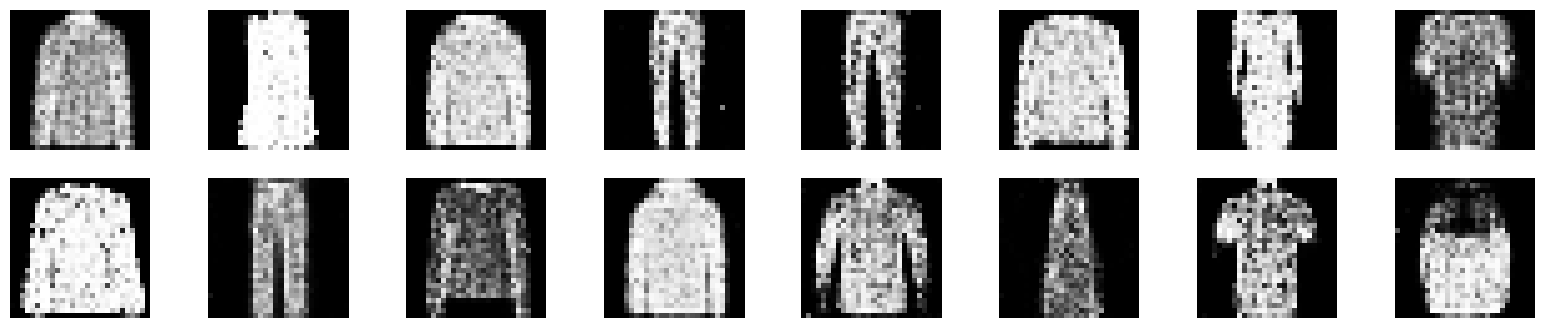

100%|██████████| 1875/1875 [00:19<00:00, 96.62it/s] 




Time for epoch 47 is 19.579233169555664 sec
Generator loss: 1.037, Discriminator loss: 0.540


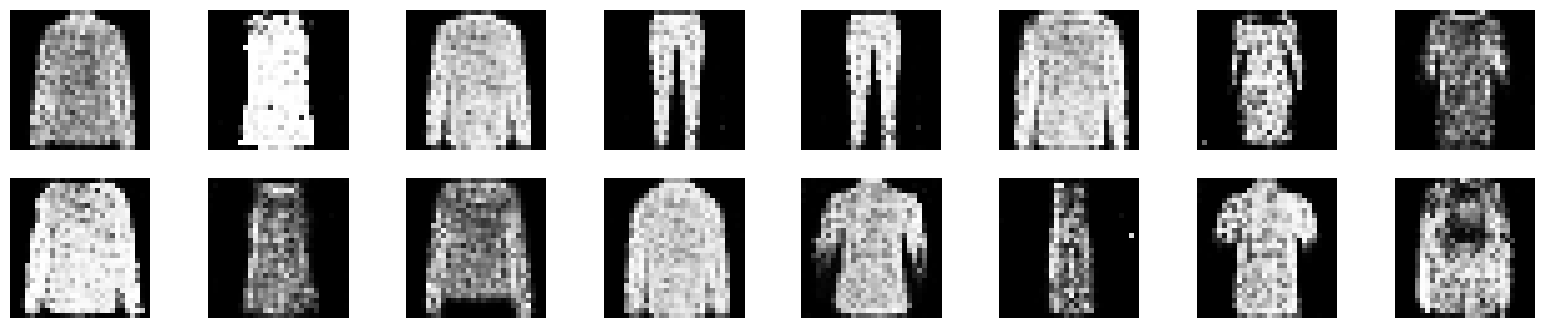

100%|██████████| 1875/1875 [00:19<00:00, 98.36it/s] 




Time for epoch 48 is 19.235946893692017 sec
Generator loss: 1.032, Discriminator loss: 0.541


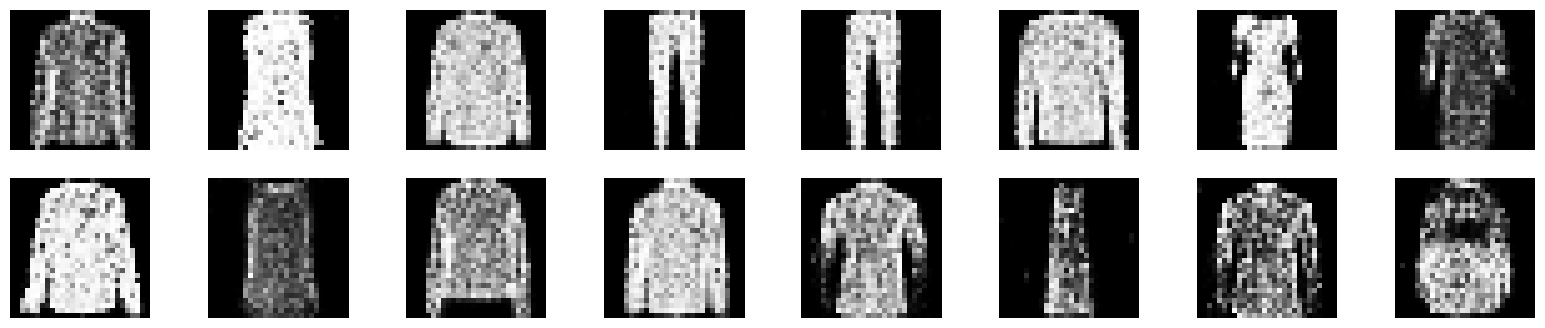

100%|██████████| 1875/1875 [00:19<00:00, 98.13it/s] 




Time for epoch 49 is 19.280346393585205 sec
Generator loss: 1.035, Discriminator loss: 0.541


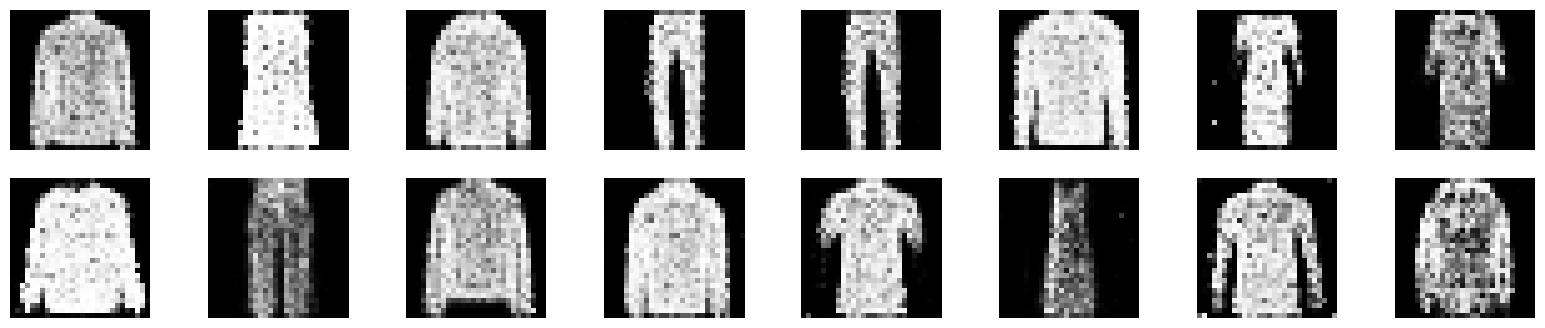

100%|██████████| 1875/1875 [00:19<00:00, 98.25it/s] 




Time for epoch 50 is 19.27942395210266 sec
Generator loss: 1.035, Discriminator loss: 0.539


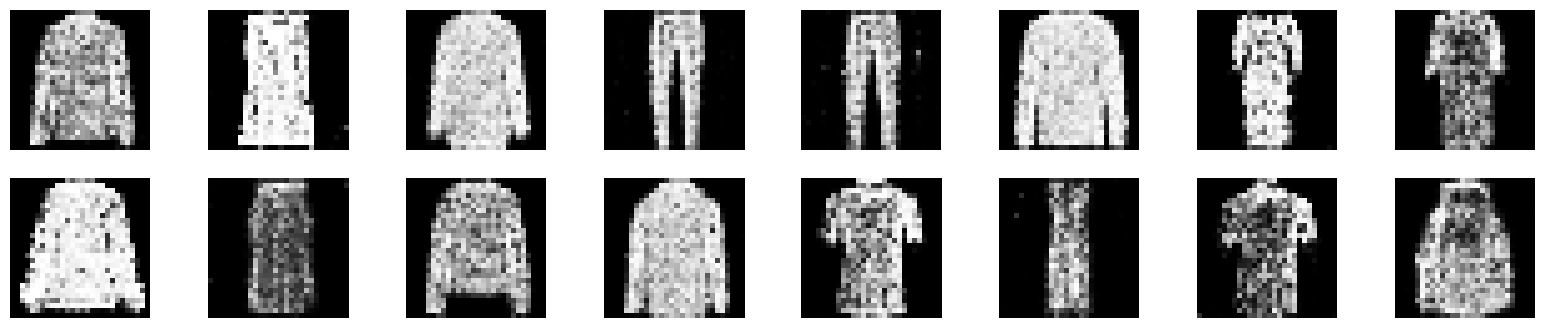

100%|██████████| 1875/1875 [00:19<00:00, 97.29it/s] 




Time for epoch 51 is 19.44756293296814 sec
Generator loss: 1.038, Discriminator loss: 0.537


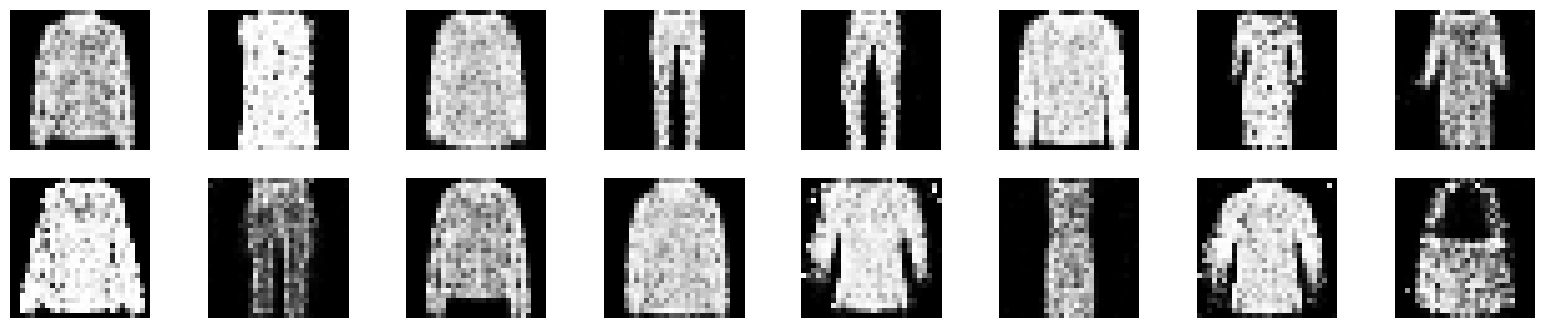

100%|██████████| 1875/1875 [00:19<00:00, 96.90it/s] 




Time for epoch 52 is 19.519011974334717 sec
Generator loss: 1.040, Discriminator loss: 0.539


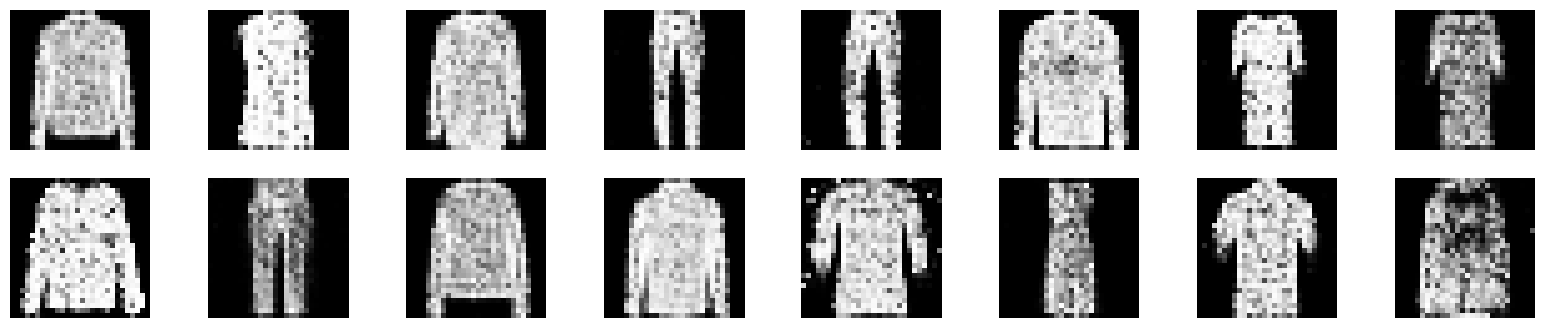

100%|██████████| 1875/1875 [00:15<00:00, 117.19it/s]




Time for epoch 53 is 16.11382508277893 sec
Generator loss: 1.039, Discriminator loss: 0.538


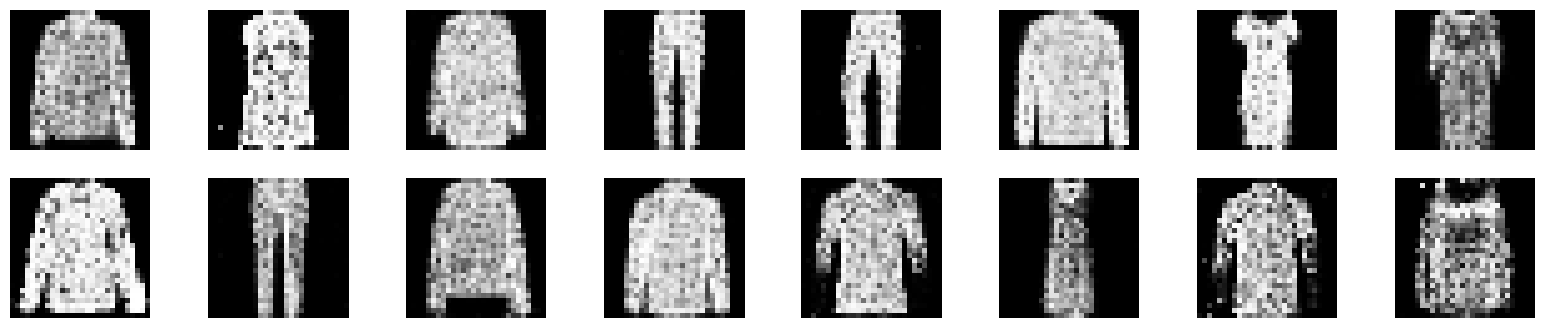

100%|██████████| 1875/1875 [00:12<00:00, 151.15it/s]




Time for epoch 54 is 12.502553224563599 sec
Generator loss: 1.040, Discriminator loss: 0.538


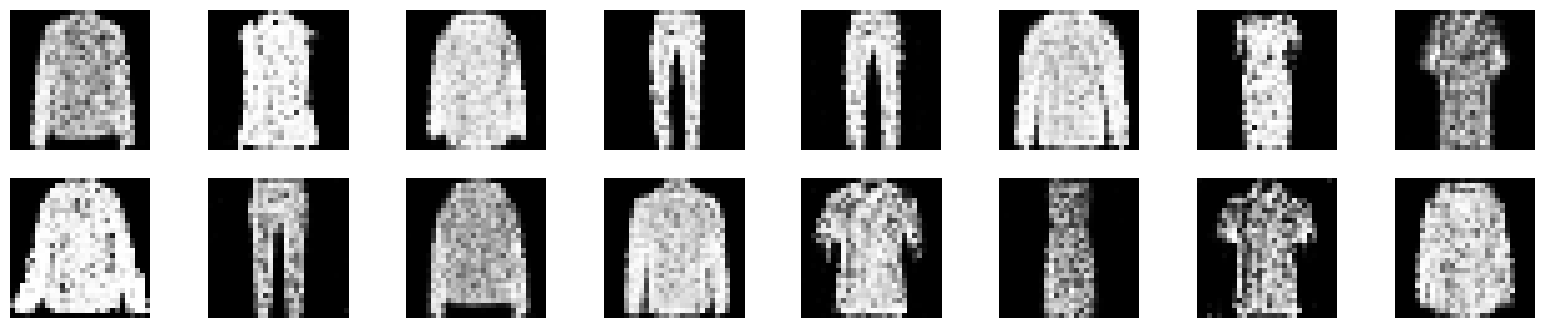

100%|██████████| 1875/1875 [00:11<00:00, 156.60it/s]




Time for epoch 55 is 12.09749722480774 sec
Generator loss: 1.044, Discriminator loss: 0.536


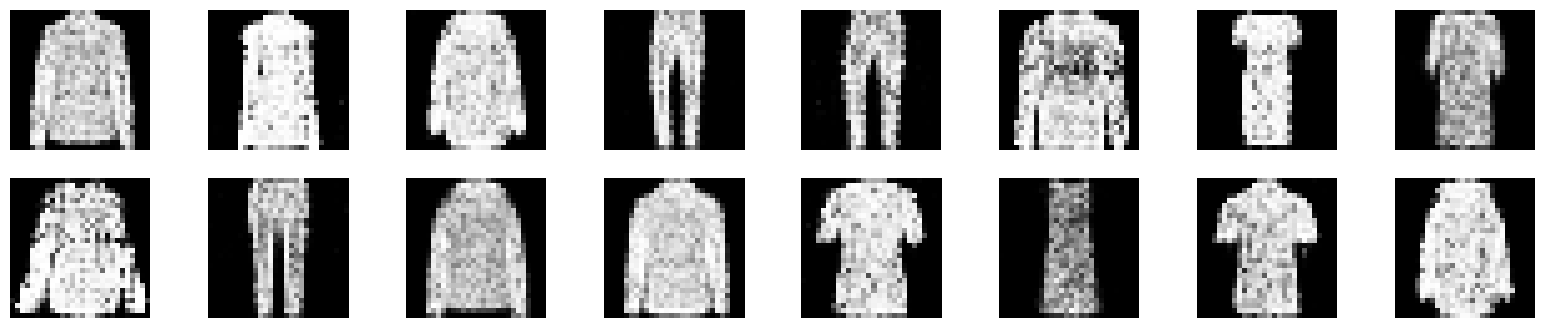

100%|██████████| 1875/1875 [00:12<00:00, 153.08it/s]




Time for epoch 56 is 12.343279838562012 sec
Generator loss: 1.044, Discriminator loss: 0.536


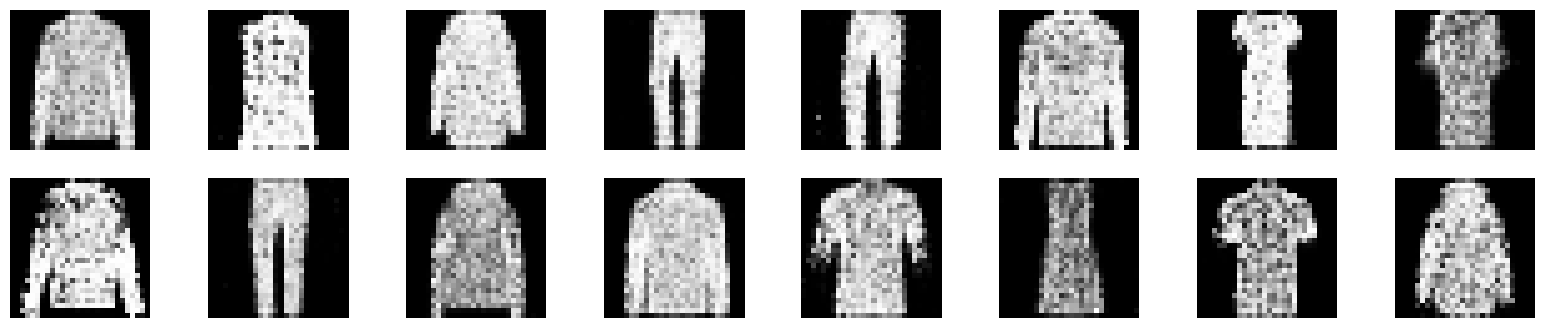

100%|██████████| 1875/1875 [00:11<00:00, 156.58it/s]




Time for epoch 57 is 12.076902151107788 sec
Generator loss: 1.044, Discriminator loss: 0.535


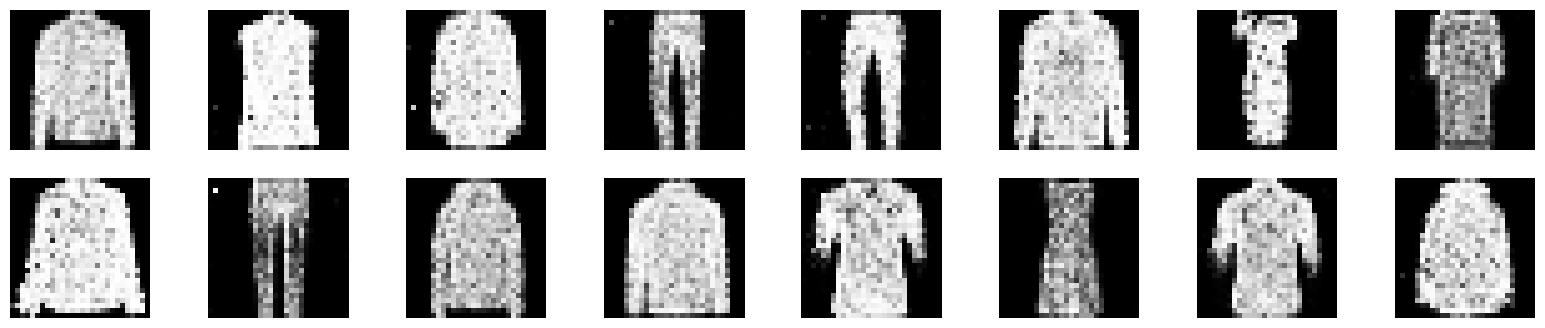

100%|██████████| 1875/1875 [00:12<00:00, 154.22it/s]




Time for epoch 58 is 12.256927967071533 sec
Generator loss: 1.045, Discriminator loss: 0.536


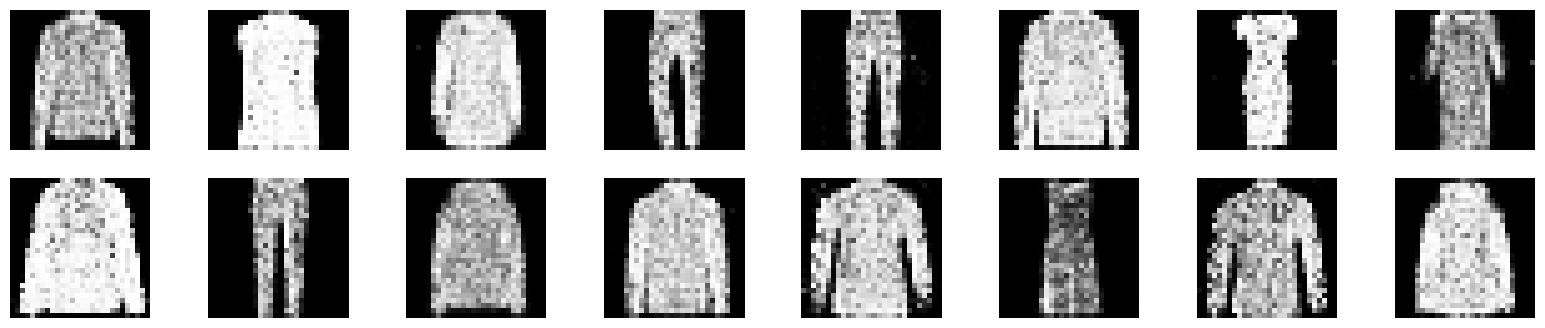

100%|██████████| 1875/1875 [00:12<00:00, 153.85it/s]




Time for epoch 59 is 12.29162335395813 sec
Generator loss: 1.047, Discriminator loss: 0.534


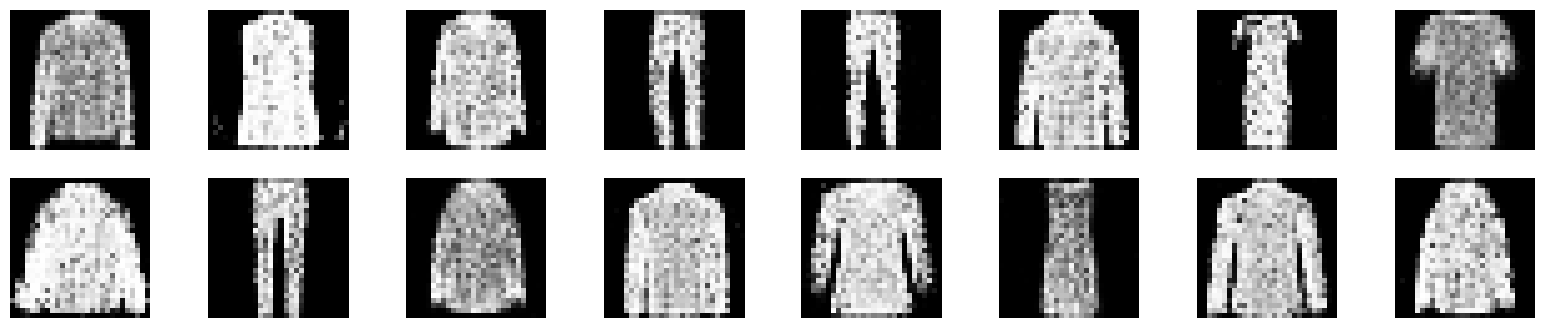

100%|██████████| 1875/1875 [00:12<00:00, 151.20it/s]




Time for epoch 60 is 12.518998861312866 sec
Generator loss: 1.048, Discriminator loss: 0.534


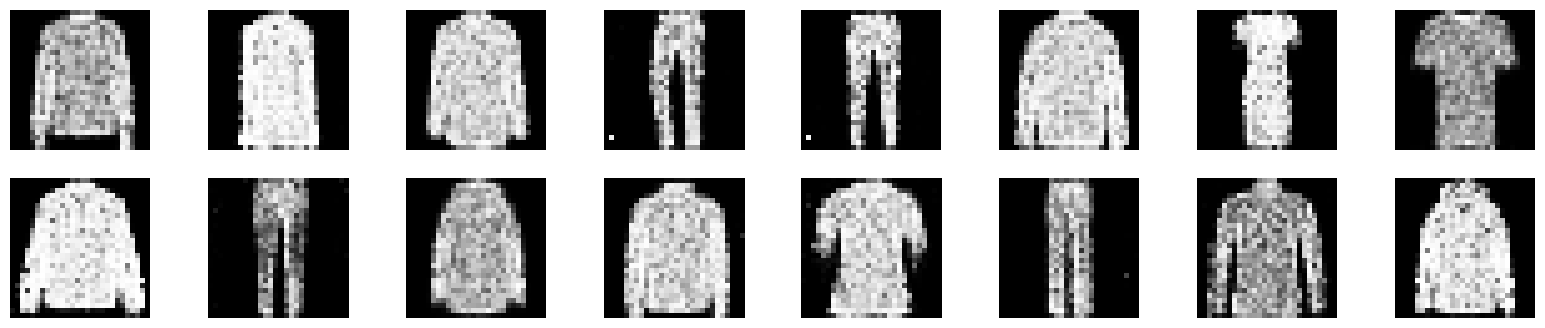

100%|██████████| 1875/1875 [00:12<00:00, 151.13it/s]




Time for epoch 61 is 12.510556936264038 sec
Generator loss: 1.048, Discriminator loss: 0.535


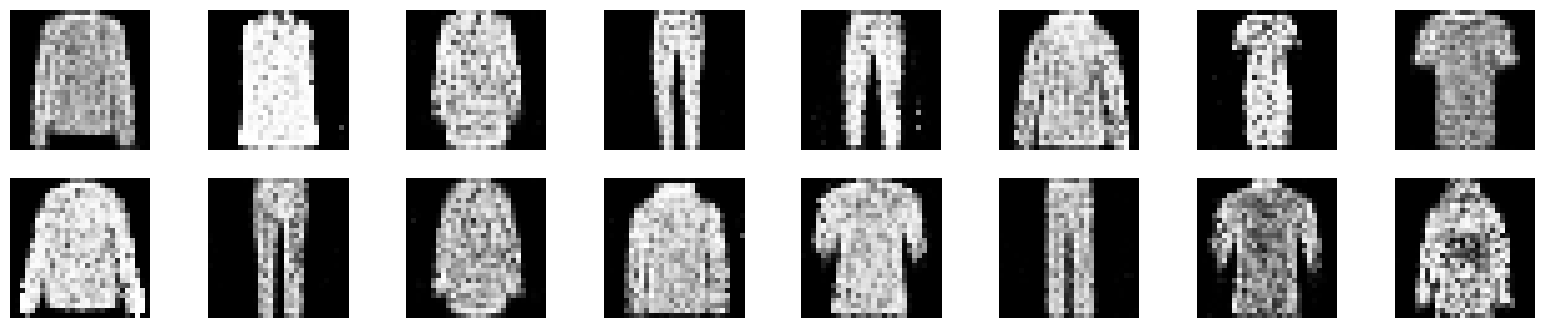

100%|██████████| 1875/1875 [00:12<00:00, 145.31it/s]




Time for epoch 62 is 13.005815029144287 sec
Generator loss: 1.051, Discriminator loss: 0.533


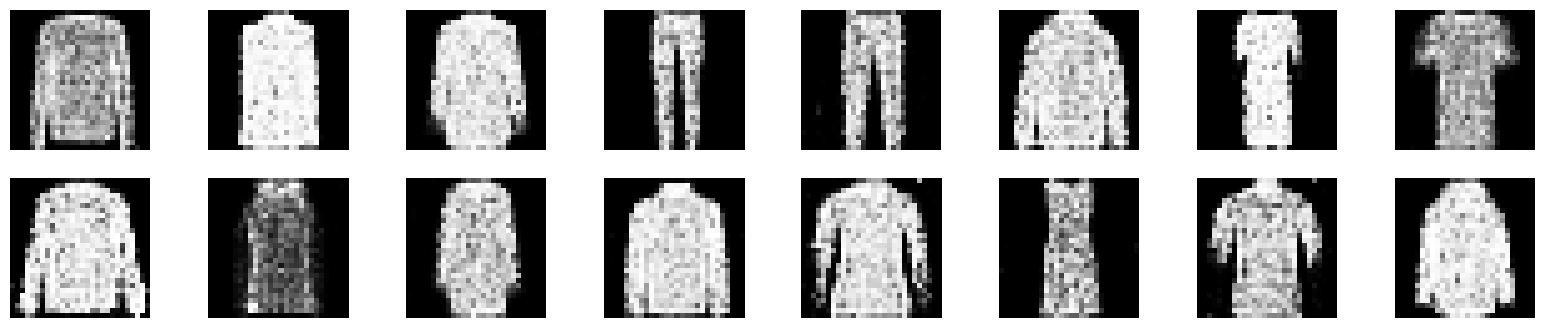

100%|██████████| 1875/1875 [00:12<00:00, 151.92it/s]




Time for epoch 63 is 12.455641031265259 sec
Generator loss: 1.050, Discriminator loss: 0.533


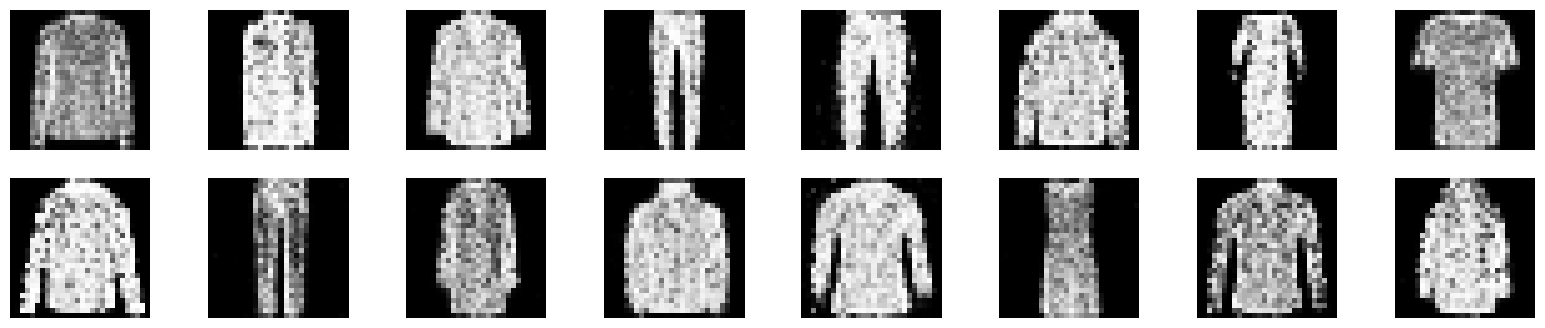

100%|██████████| 1875/1875 [00:12<00:00, 145.98it/s]




Time for epoch 64 is 12.950747966766357 sec
Generator loss: 1.053, Discriminator loss: 0.531


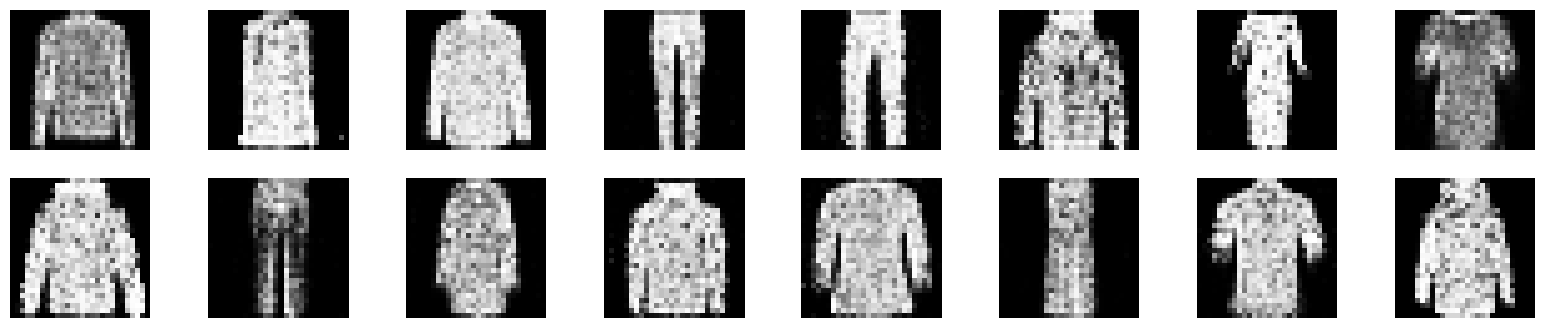

100%|██████████| 1875/1875 [00:12<00:00, 154.34it/s]




Time for epoch 65 is 12.2624831199646 sec
Generator loss: 1.052, Discriminator loss: 0.533


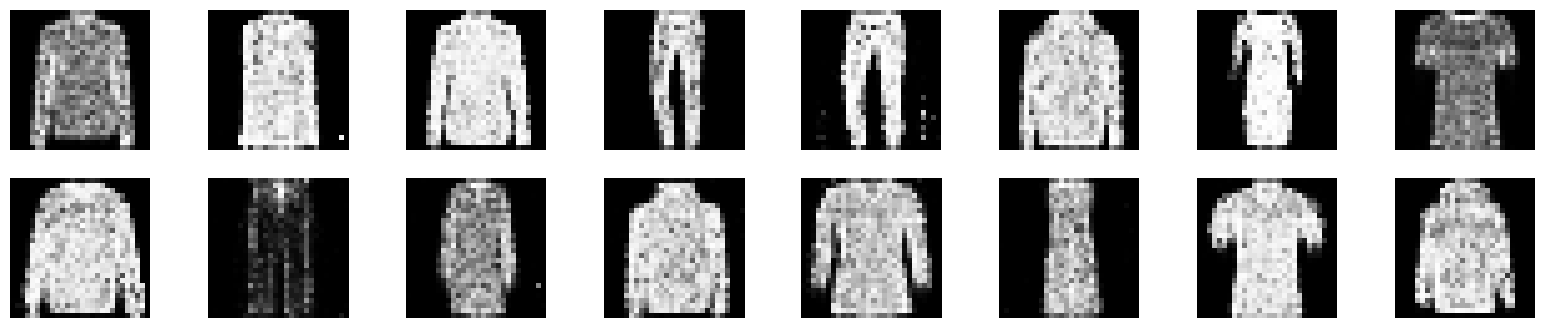

100%|██████████| 1875/1875 [00:12<00:00, 152.40it/s]




Time for epoch 66 is 12.408007860183716 sec
Generator loss: 1.059, Discriminator loss: 0.530


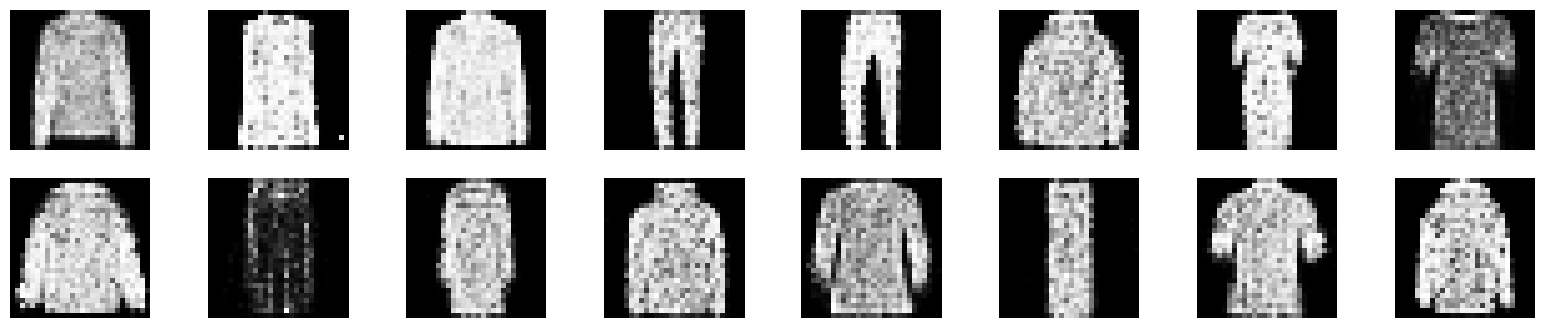

100%|██████████| 1875/1875 [00:12<00:00, 149.99it/s]




Time for epoch 67 is 12.626443862915039 sec
Generator loss: 1.052, Discriminator loss: 0.532


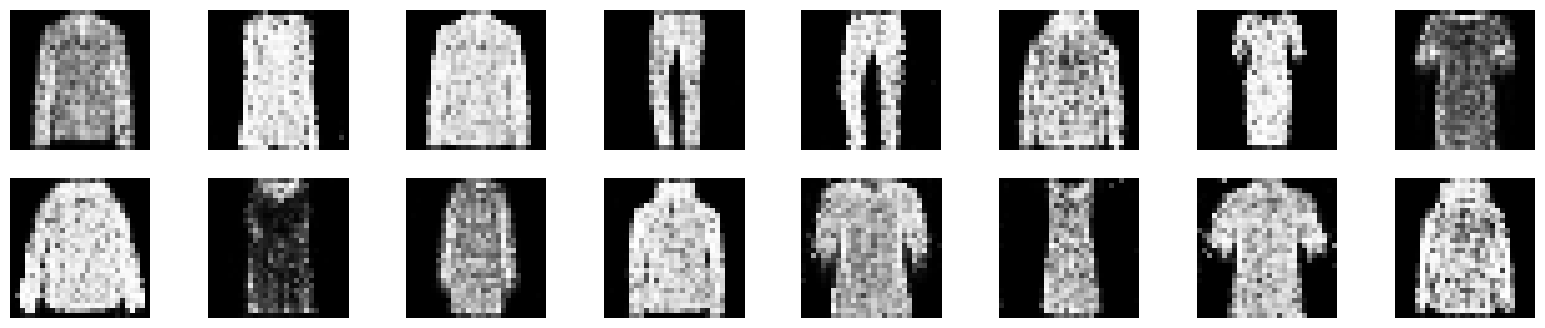

100%|██████████| 1875/1875 [00:12<00:00, 150.59it/s]




Time for epoch 68 is 12.554605960845947 sec
Generator loss: 1.055, Discriminator loss: 0.531


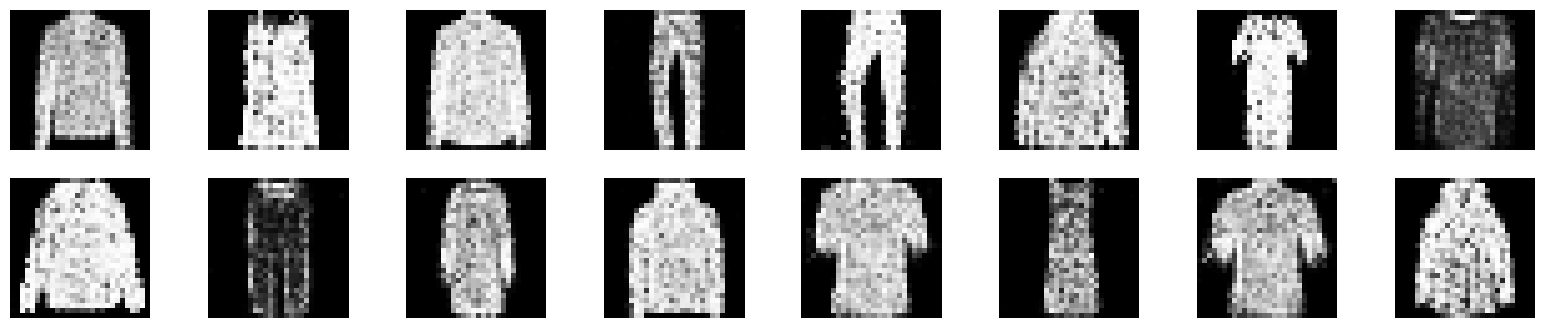

100%|██████████| 1875/1875 [00:12<00:00, 150.70it/s]




Time for epoch 69 is 12.540860891342163 sec
Generator loss: 1.053, Discriminator loss: 0.532


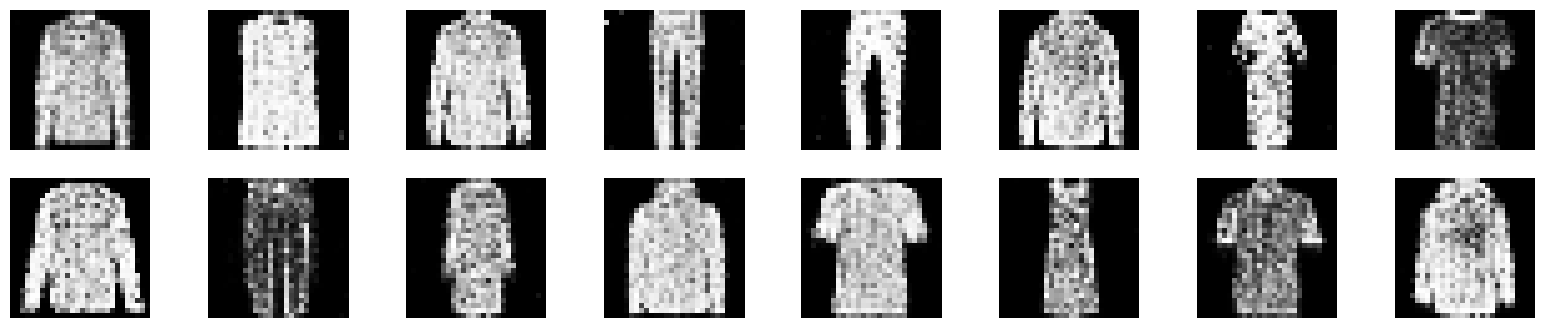

100%|██████████| 1875/1875 [00:12<00:00, 146.57it/s]




Time for epoch 70 is 12.899421691894531 sec
Generator loss: 1.056, Discriminator loss: 0.531


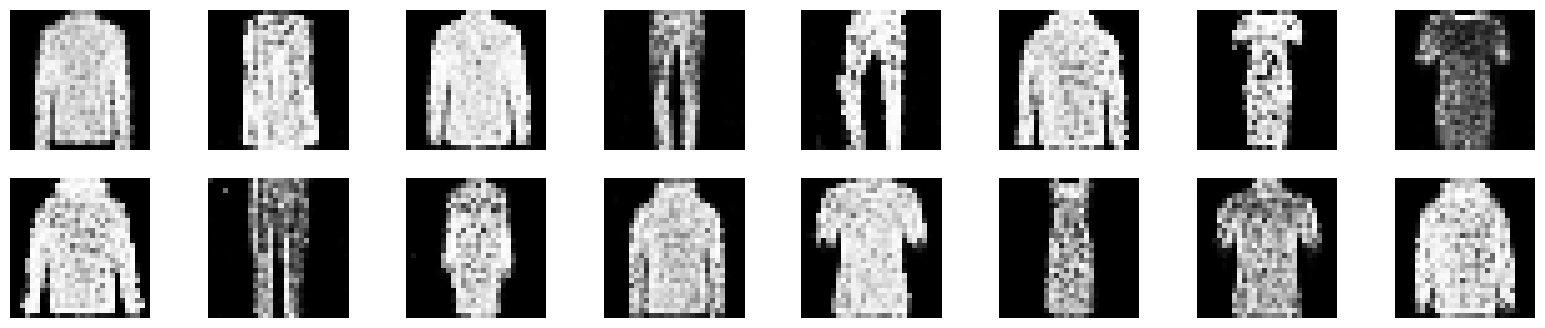

100%|██████████| 1875/1875 [00:12<00:00, 149.75it/s]




Time for epoch 71 is 12.621651887893677 sec
Generator loss: 1.059, Discriminator loss: 0.529


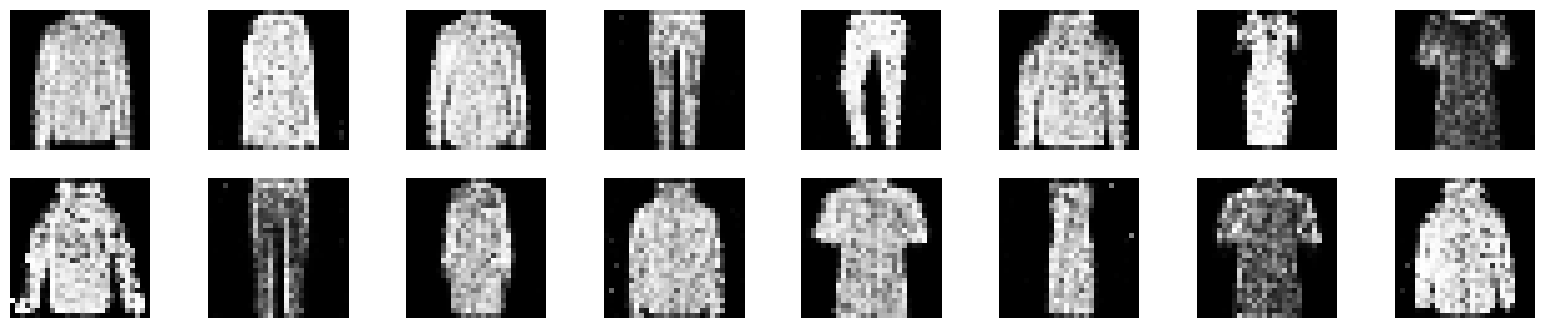

100%|██████████| 1875/1875 [00:11<00:00, 156.95it/s]




Time for epoch 72 is 12.05251169204712 sec
Generator loss: 1.060, Discriminator loss: 0.529


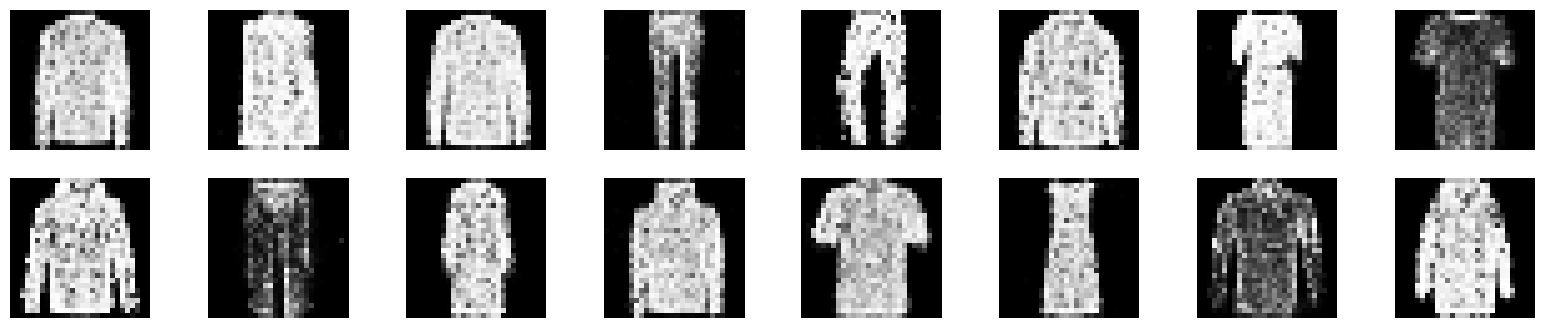

100%|██████████| 1875/1875 [00:19<00:00, 98.34it/s] 




Time for epoch 73 is 19.236622095108032 sec
Generator loss: 1.060, Discriminator loss: 0.529


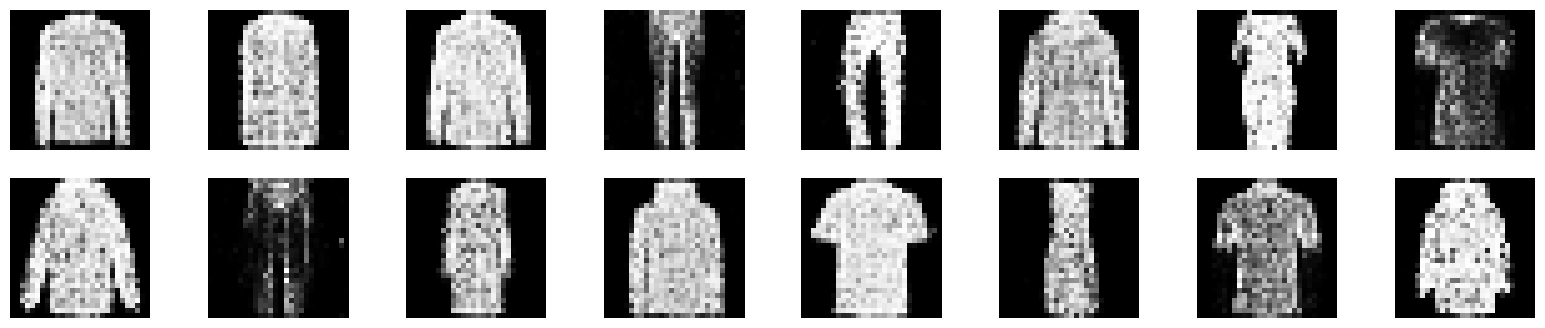

100%|██████████| 1875/1875 [00:19<00:00, 95.24it/s] 




Time for epoch 74 is 19.865521907806396 sec
Generator loss: 1.062, Discriminator loss: 0.528


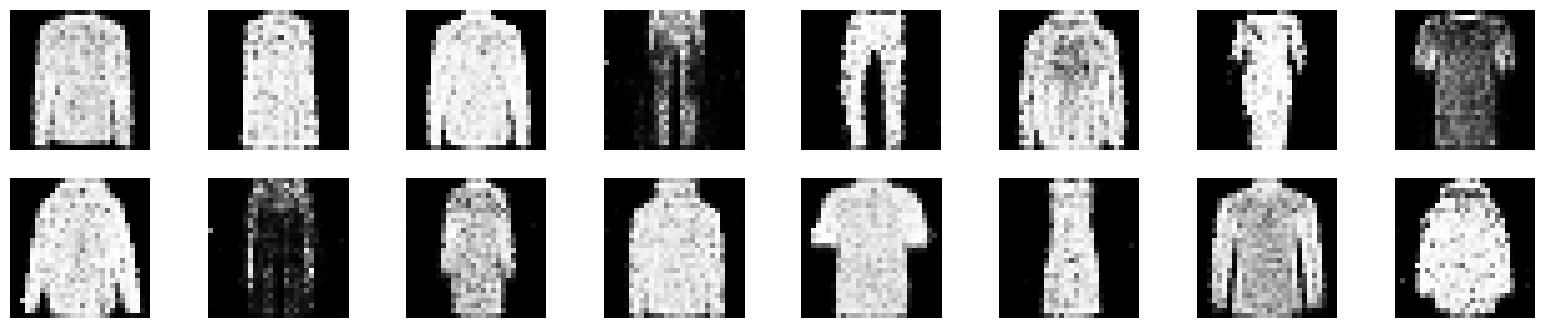

100%|██████████| 1875/1875 [00:19<00:00, 94.38it/s] 




Time for epoch 75 is 20.063335180282593 sec
Generator loss: 1.062, Discriminator loss: 0.528


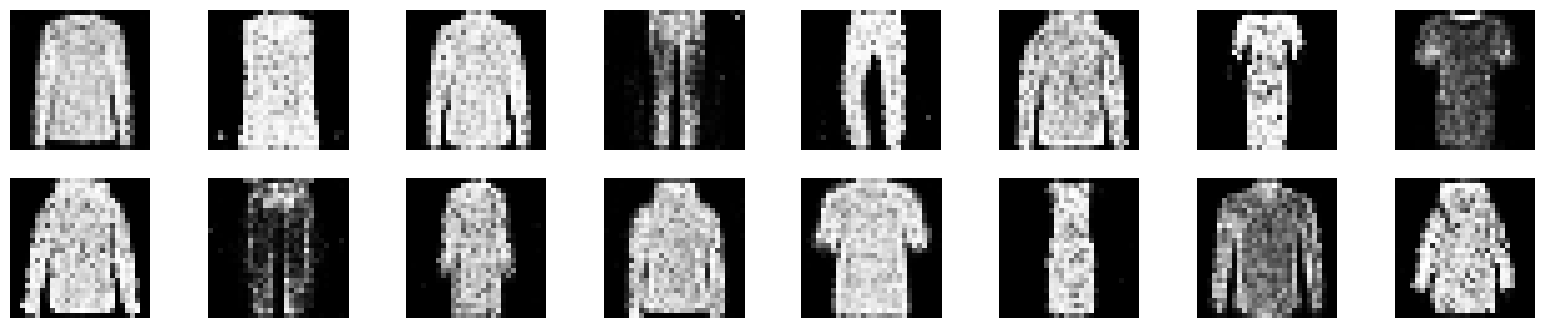

100%|██████████| 1875/1875 [00:19<00:00, 96.08it/s] 




Time for epoch 76 is 19.687998056411743 sec
Generator loss: 1.065, Discriminator loss: 0.527


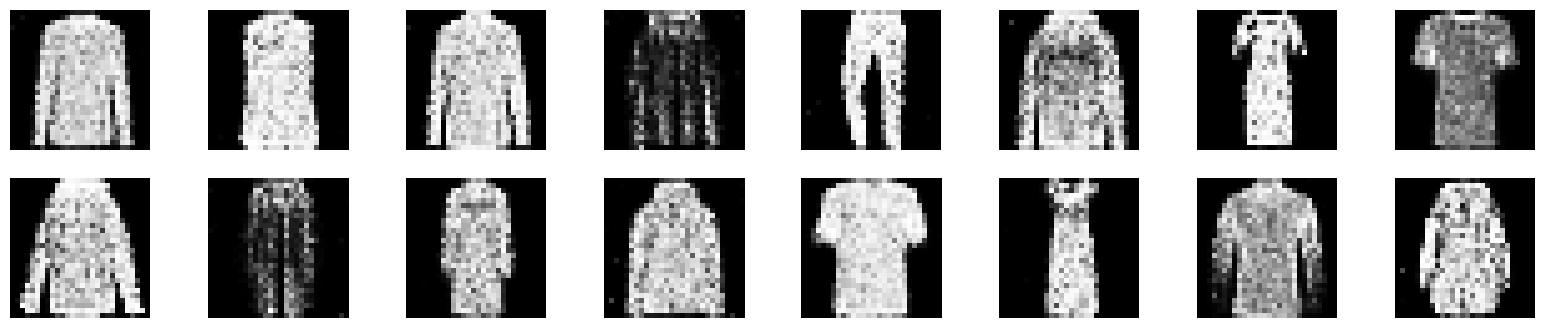

100%|██████████| 1875/1875 [00:19<00:00, 96.49it/s] 




Time for epoch 77 is 19.626274347305298 sec
Generator loss: 1.066, Discriminator loss: 0.527


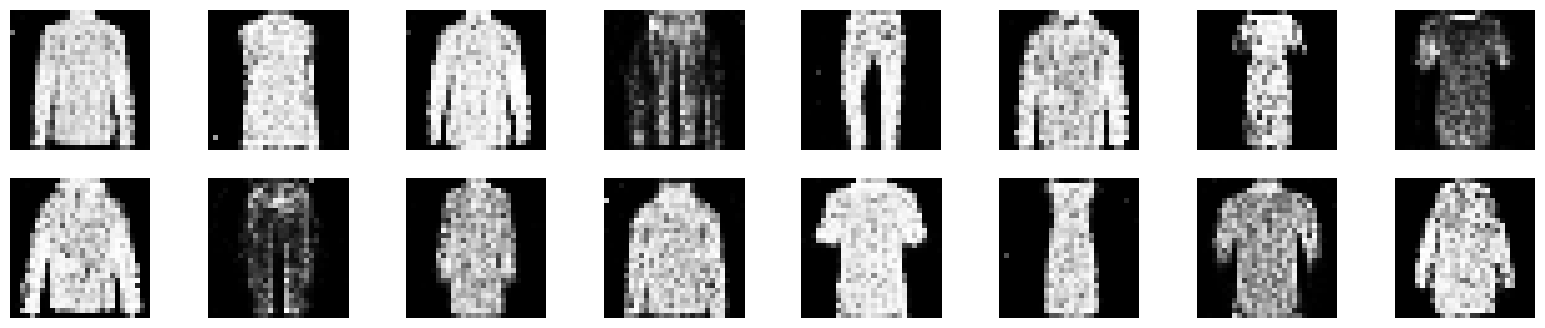

100%|██████████| 1875/1875 [00:19<00:00, 95.27it/s] 




Time for epoch 78 is 19.85911226272583 sec
Generator loss: 1.066, Discriminator loss: 0.527


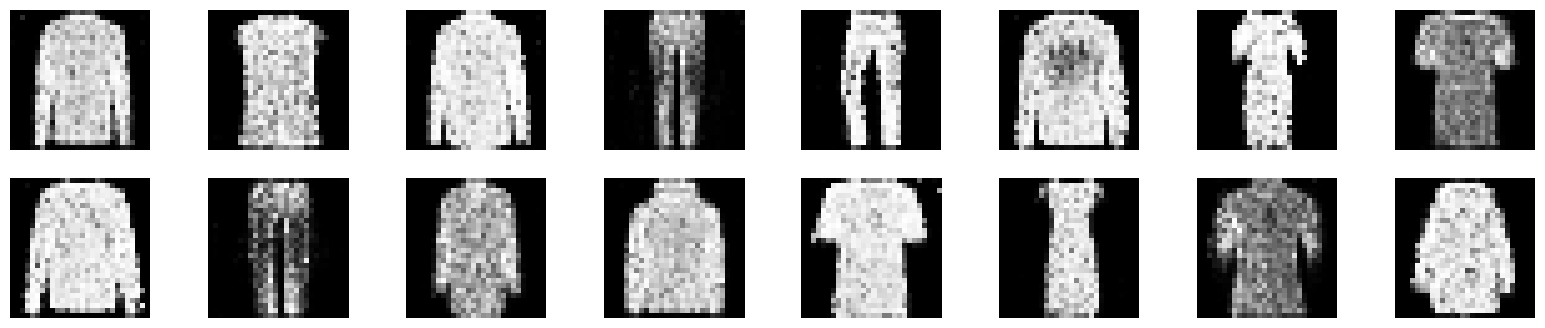

100%|██████████| 1875/1875 [00:19<00:00, 95.25it/s] 




Time for epoch 79 is 19.864551782608032 sec
Generator loss: 1.069, Discriminator loss: 0.526


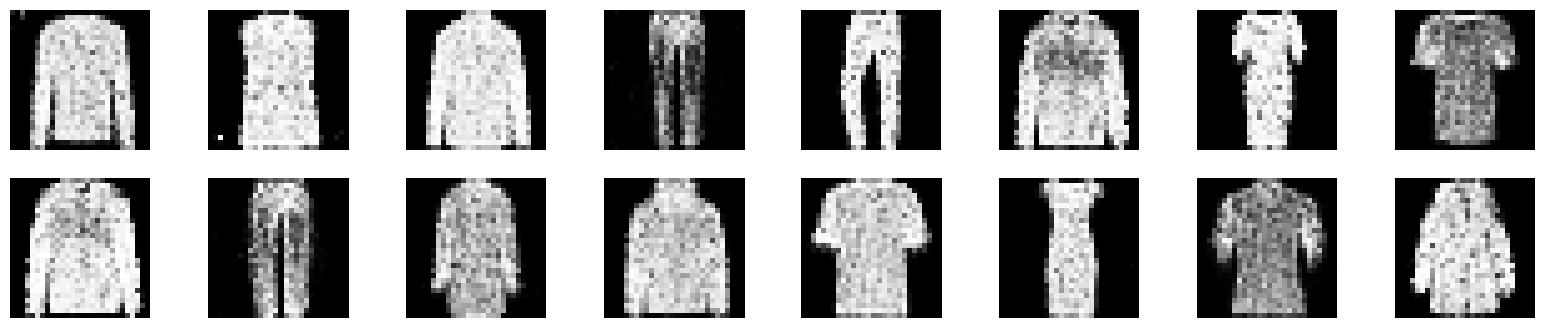

100%|██████████| 1875/1875 [00:19<00:00, 95.61it/s] 




Time for epoch 80 is 19.80648922920227 sec
Generator loss: 1.075, Discriminator loss: 0.525


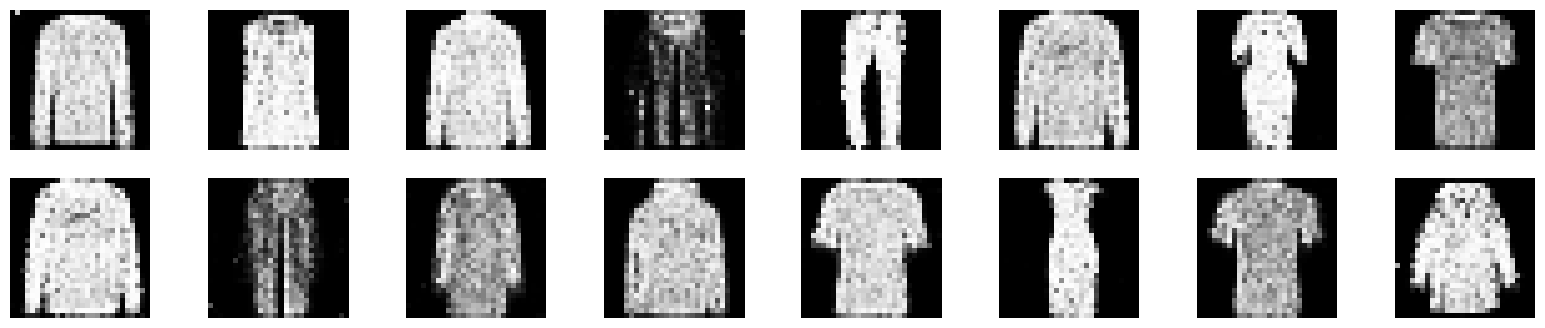

100%|██████████| 1875/1875 [00:19<00:00, 97.00it/s] 




Time for epoch 81 is 19.505111694335938 sec
Generator loss: 1.073, Discriminator loss: 0.526


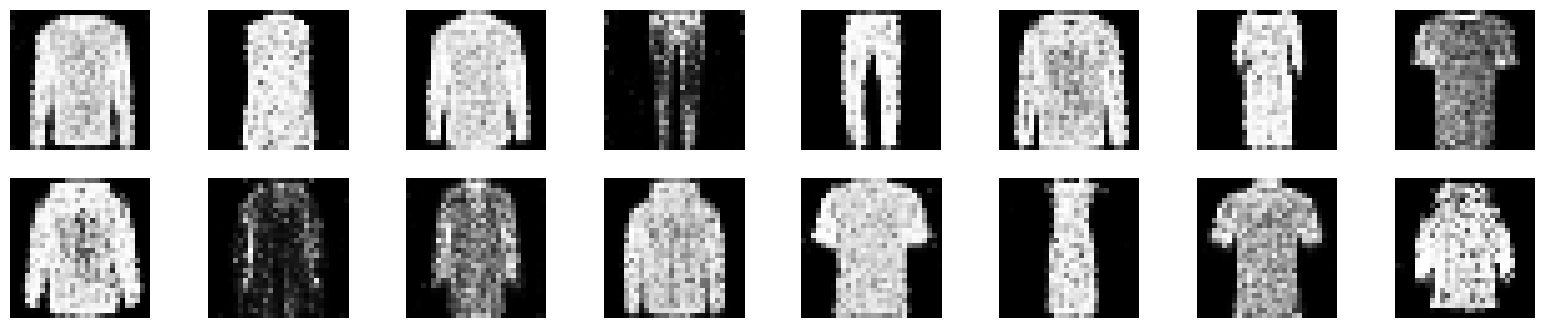

100%|██████████| 1875/1875 [00:15<00:00, 121.91it/s]




Time for epoch 82 is 15.491705894470215 sec
Generator loss: 1.076, Discriminator loss: 0.524


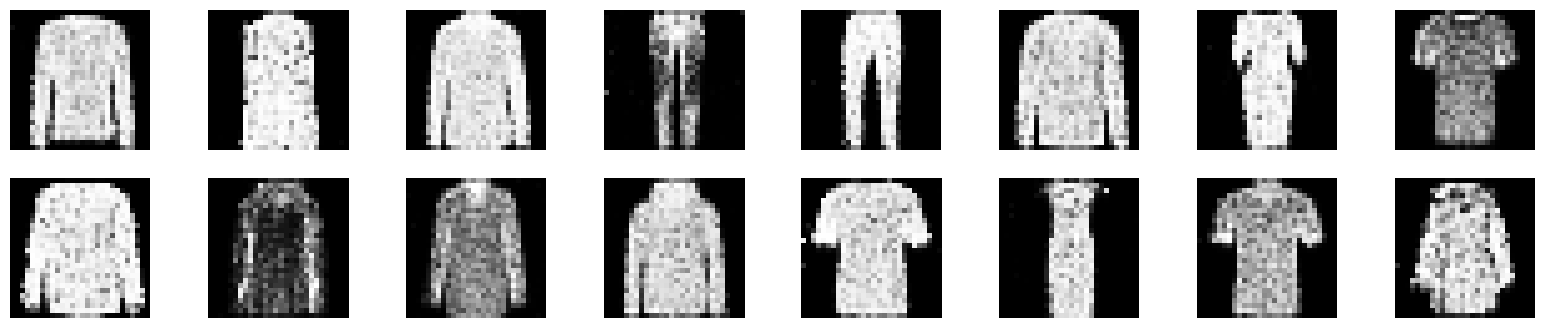

100%|██████████| 1875/1875 [00:11<00:00, 159.08it/s]




Time for epoch 83 is 11.891357183456421 sec
Generator loss: 1.079, Discriminator loss: 0.523


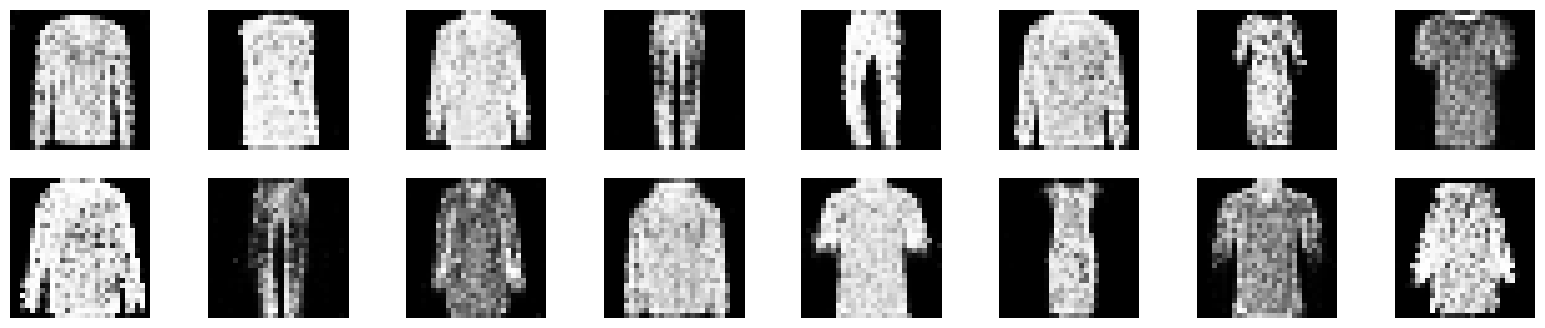

100%|██████████| 1875/1875 [00:12<00:00, 155.09it/s]




Time for epoch 84 is 12.189950227737427 sec
Generator loss: 1.082, Discriminator loss: 0.523


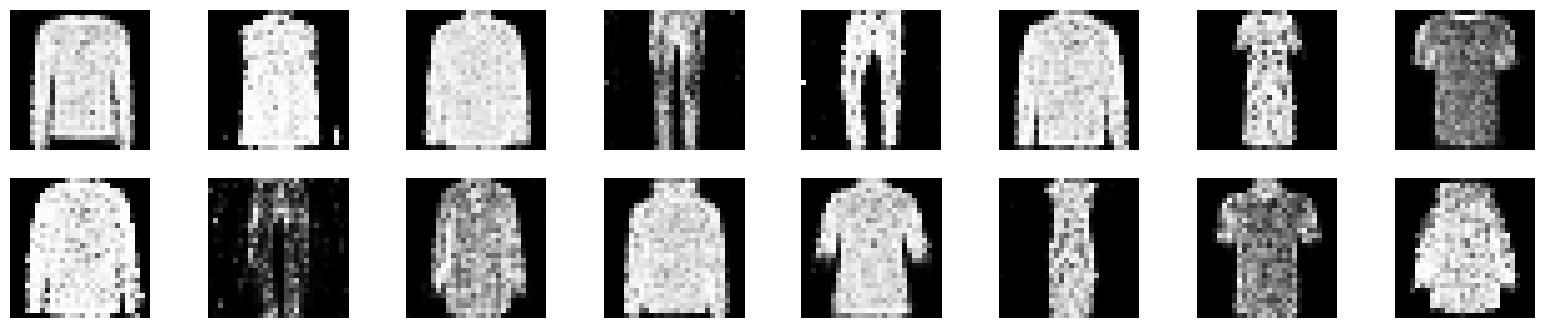

100%|██████████| 1875/1875 [00:12<00:00, 153.16it/s]




Time for epoch 85 is 12.353892803192139 sec
Generator loss: 1.083, Discriminator loss: 0.522


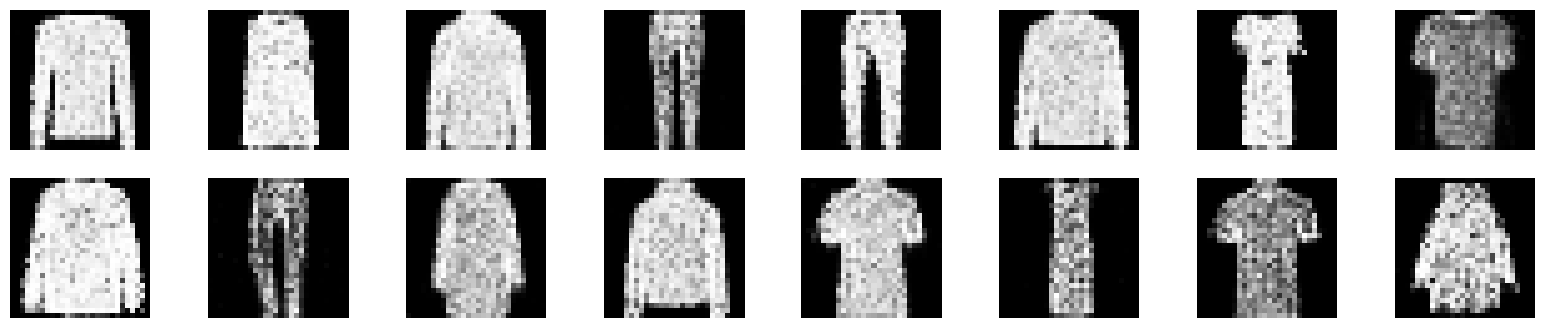

100%|██████████| 1875/1875 [00:12<00:00, 151.12it/s]




Time for epoch 86 is 12.516511678695679 sec
Generator loss: 1.082, Discriminator loss: 0.522


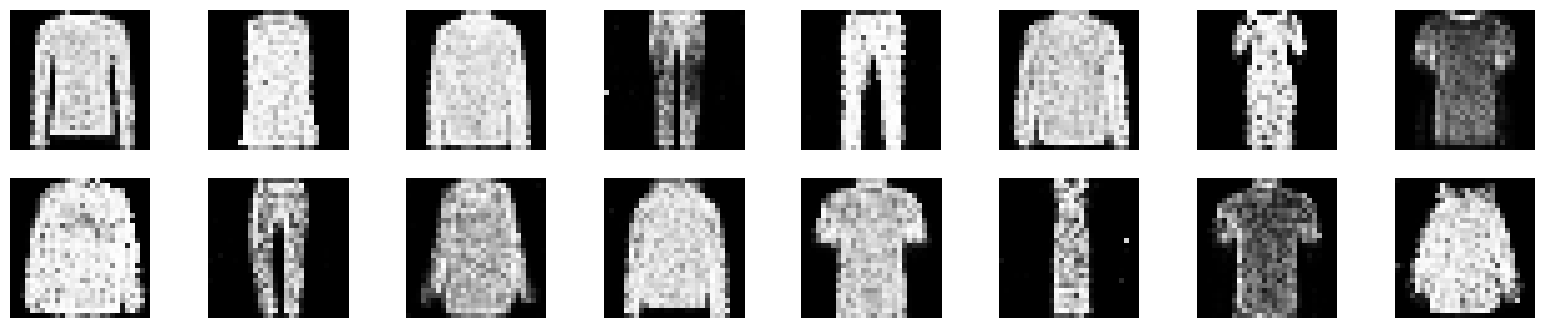

100%|██████████| 1875/1875 [00:12<00:00, 156.07it/s]



Time for epoch 87 is 12.118811845779419 sec
Generator loss: 1.084, Discriminator loss: 0.522


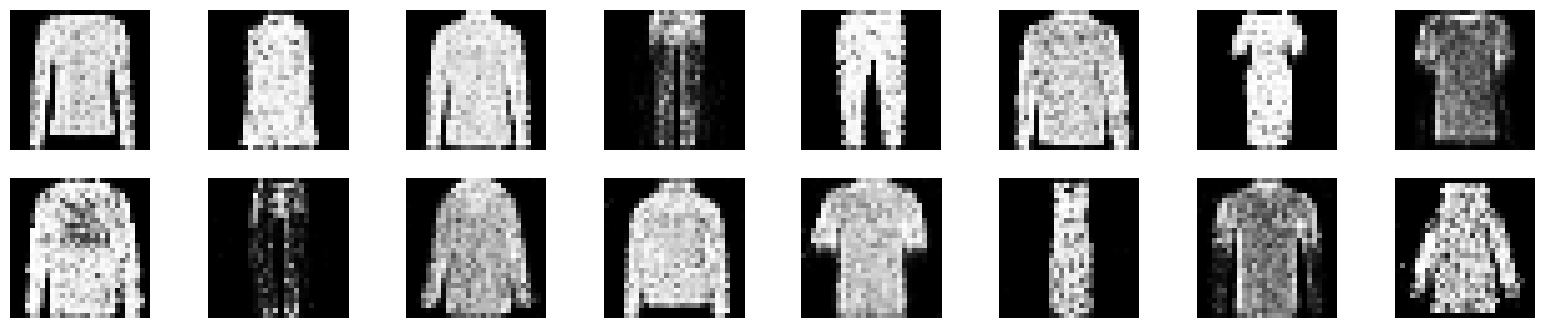

100%|██████████| 1875/1875 [00:11<00:00, 162.33it/s]




Time for epoch 88 is 11.654744148254395 sec
Generator loss: 1.087, Discriminator loss: 0.522


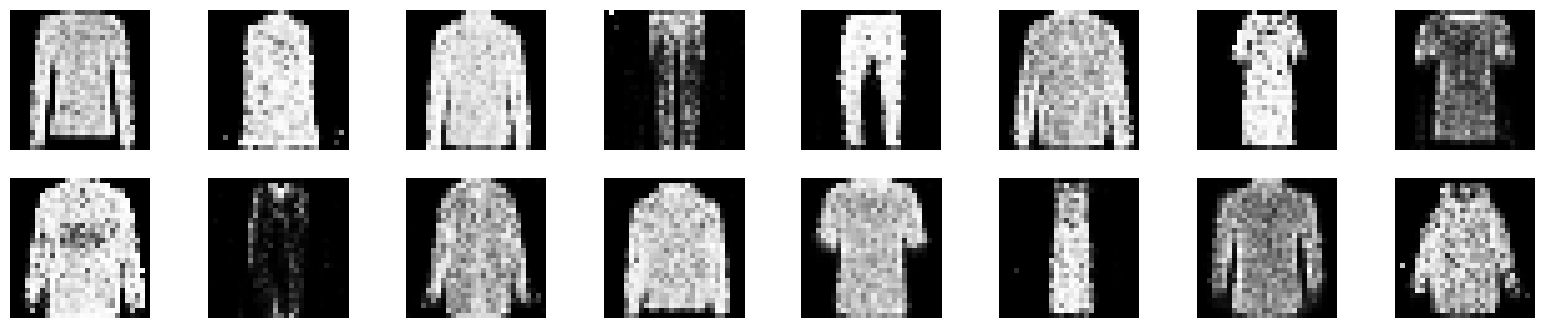

100%|██████████| 1875/1875 [00:11<00:00, 161.10it/s]




Time for epoch 89 is 11.751718997955322 sec
Generator loss: 1.085, Discriminator loss: 0.522


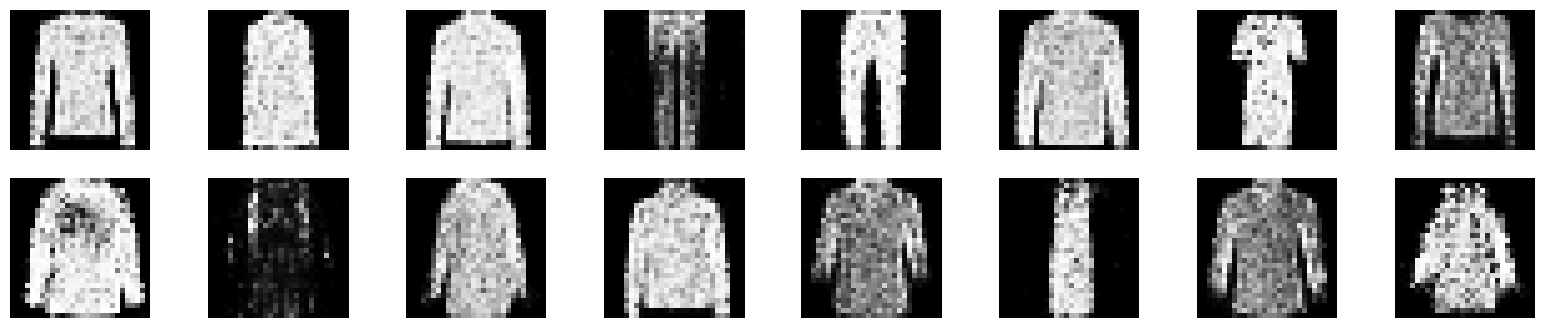

100%|██████████| 1875/1875 [00:11<00:00, 166.15it/s]




Time for epoch 90 is 11.414518594741821 sec
Generator loss: 1.090, Discriminator loss: 0.520


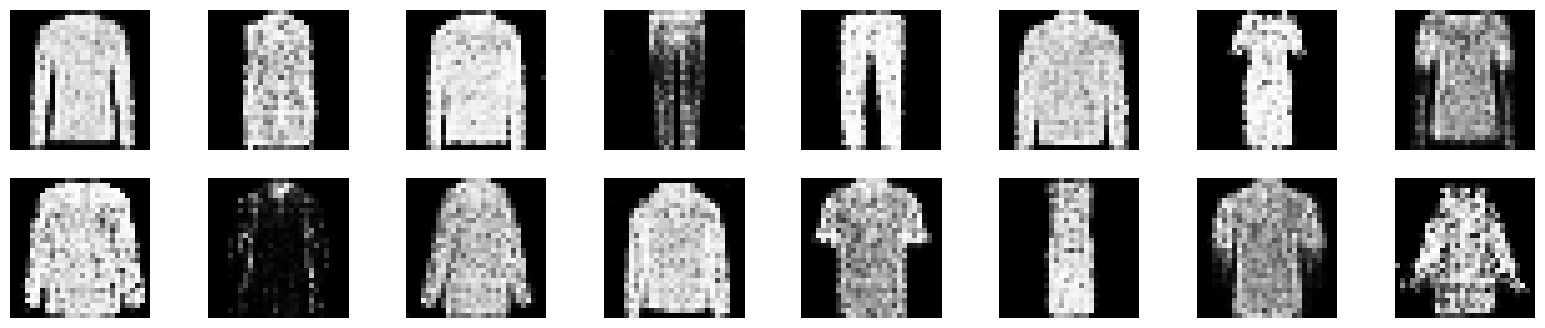

100%|██████████| 1875/1875 [00:11<00:00, 160.26it/s]




Time for epoch 91 is 11.800530195236206 sec
Generator loss: 1.092, Discriminator loss: 0.520


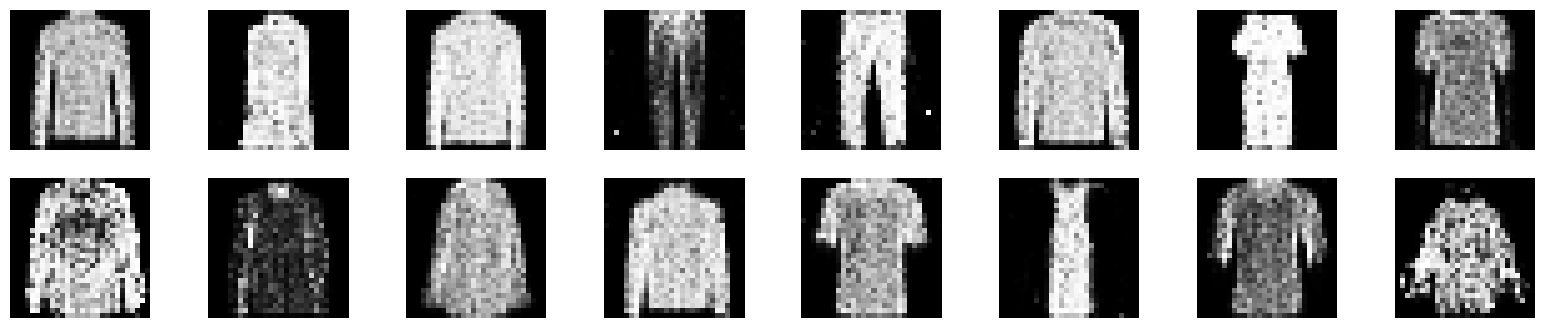

100%|██████████| 1875/1875 [00:12<00:00, 151.53it/s]




Time for epoch 92 is 12.475725173950195 sec
Generator loss: 1.094, Discriminator loss: 0.519


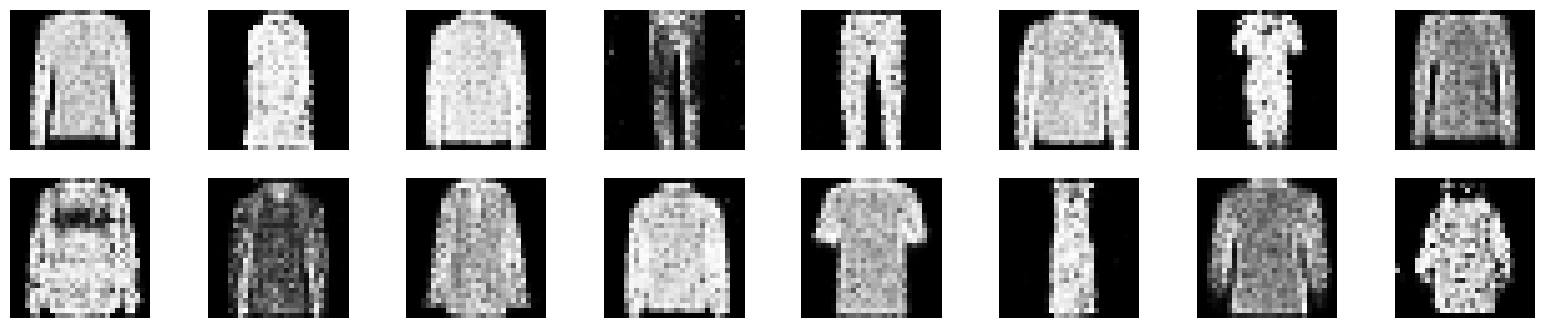

100%|██████████| 1875/1875 [00:11<00:00, 164.02it/s]




Time for epoch 93 is 11.53040099143982 sec
Generator loss: 1.090, Discriminator loss: 0.520


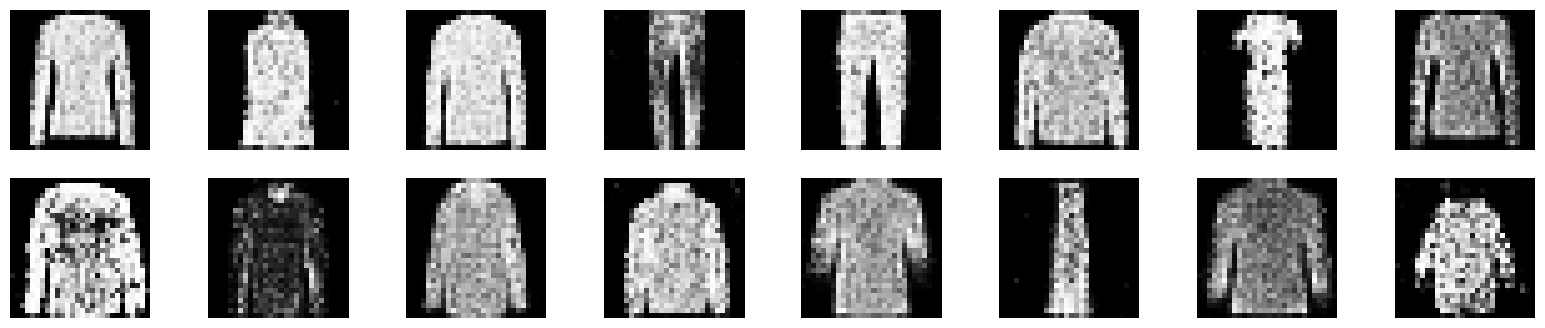

100%|██████████| 1875/1875 [00:11<00:00, 161.46it/s]




Time for epoch 94 is 11.709008693695068 sec
Generator loss: 1.094, Discriminator loss: 0.519


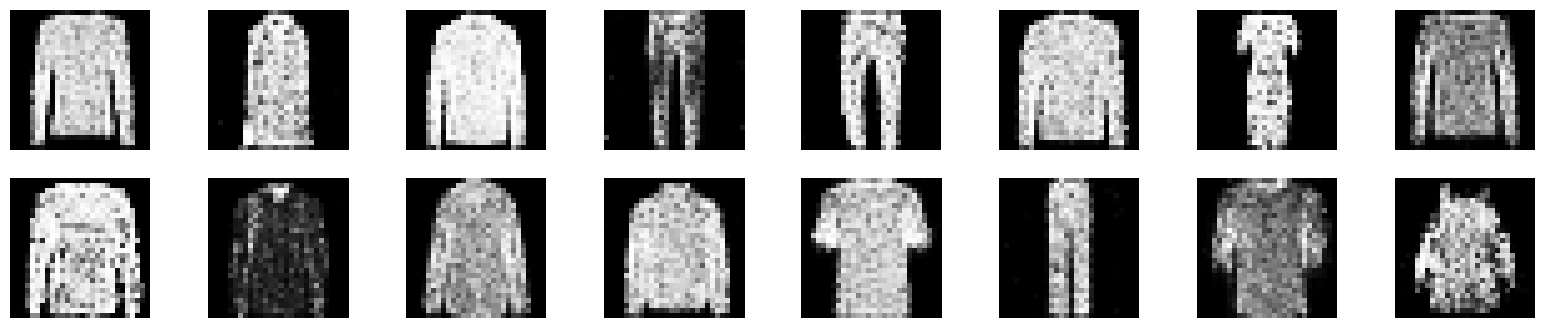

100%|██████████| 1875/1875 [00:11<00:00, 163.63it/s]




Time for epoch 95 is 11.572474718093872 sec
Generator loss: 1.100, Discriminator loss: 0.517


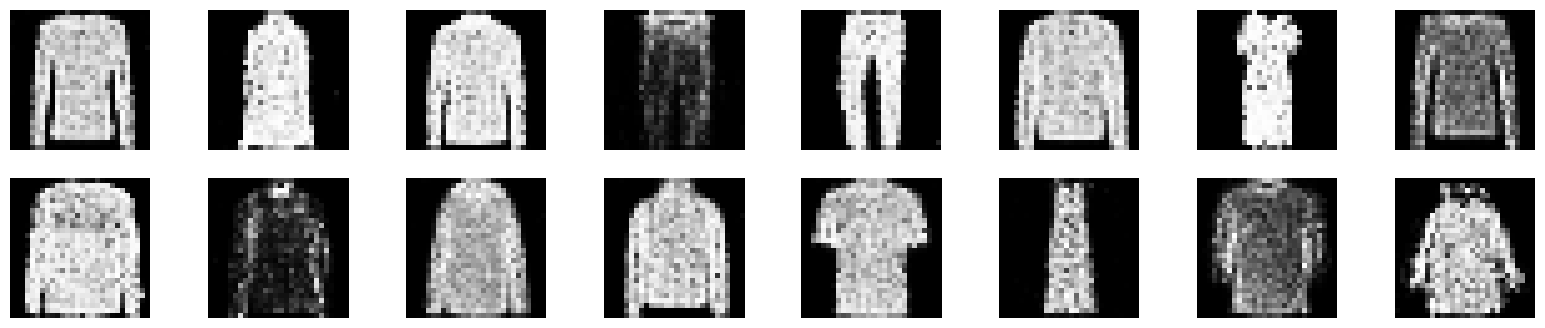

100%|██████████| 1875/1875 [00:12<00:00, 149.42it/s]




Time for epoch 96 is 12.666510820388794 sec
Generator loss: 1.102, Discriminator loss: 0.516


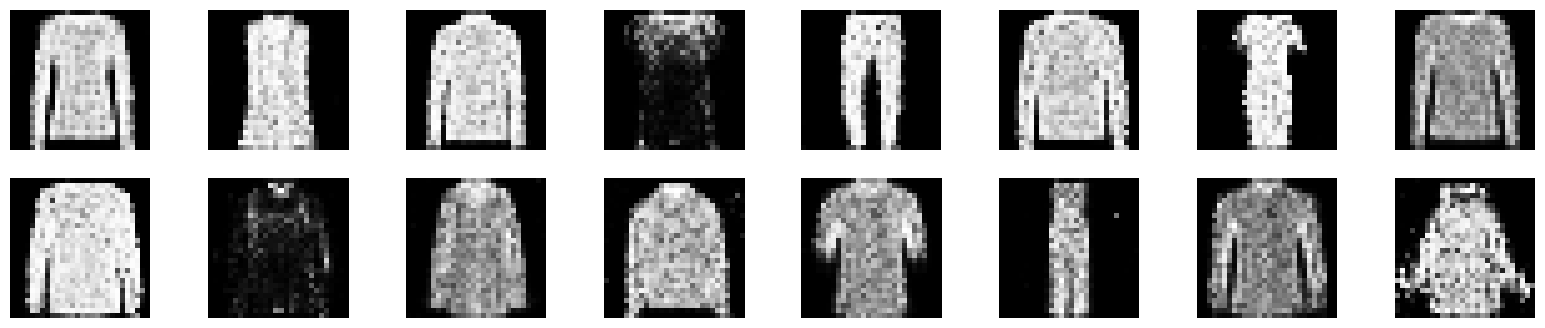

100%|██████████| 1875/1875 [00:11<00:00, 158.24it/s]




Time for epoch 97 is 11.951323986053467 sec
Generator loss: 1.104, Discriminator loss: 0.517


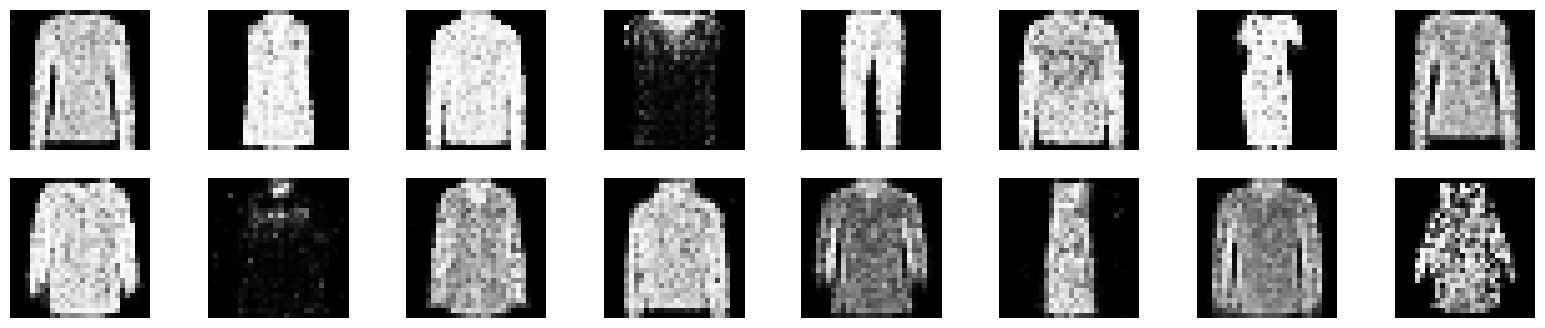

100%|██████████| 1875/1875 [00:12<00:00, 156.24it/s]




Time for epoch 98 is 12.10796046257019 sec
Generator loss: 1.106, Discriminator loss: 0.516


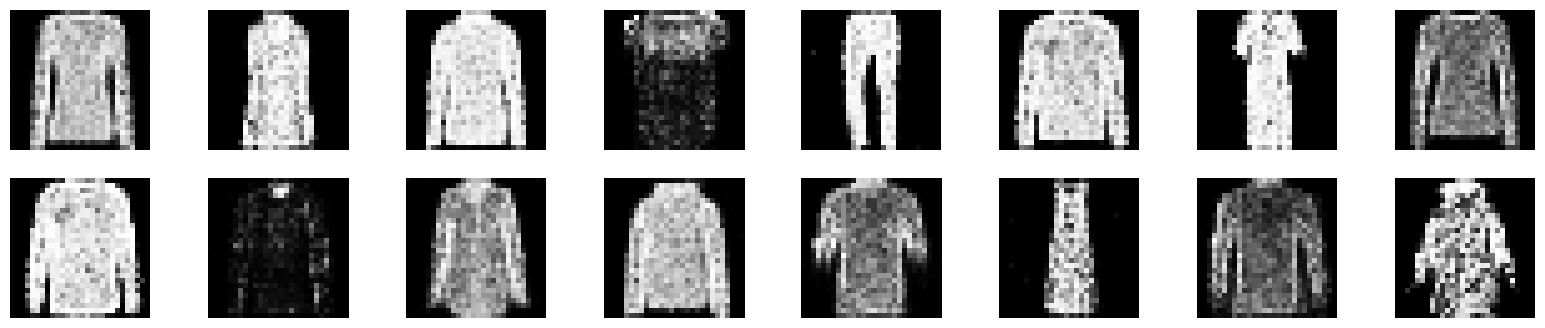

100%|██████████| 1875/1875 [00:11<00:00, 159.17it/s]




Time for epoch 99 is 11.883957862854004 sec
Generator loss: 1.107, Discriminator loss: 0.516


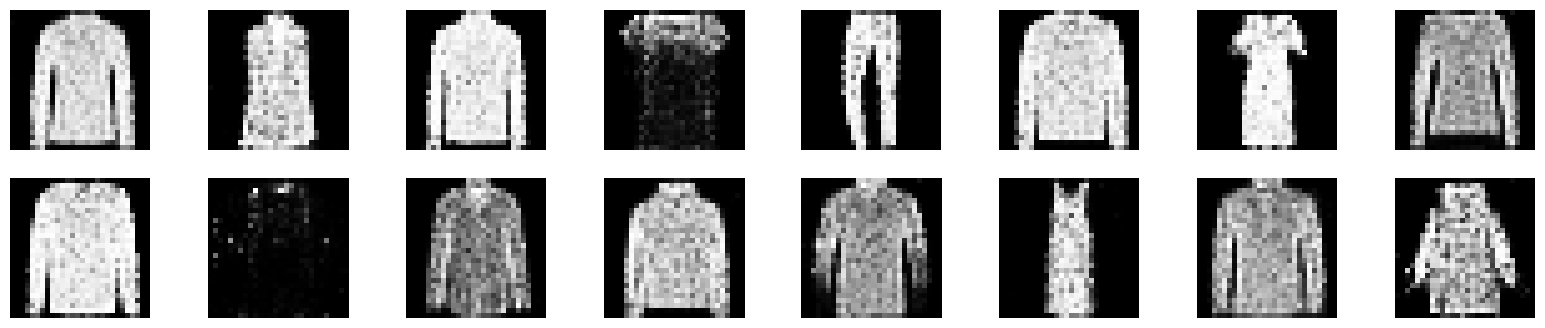

100%|██████████| 1875/1875 [00:11<00:00, 158.35it/s]




Time for epoch 100 is 11.957152128219604 sec
Generator loss: 1.110, Discriminator loss: 0.515


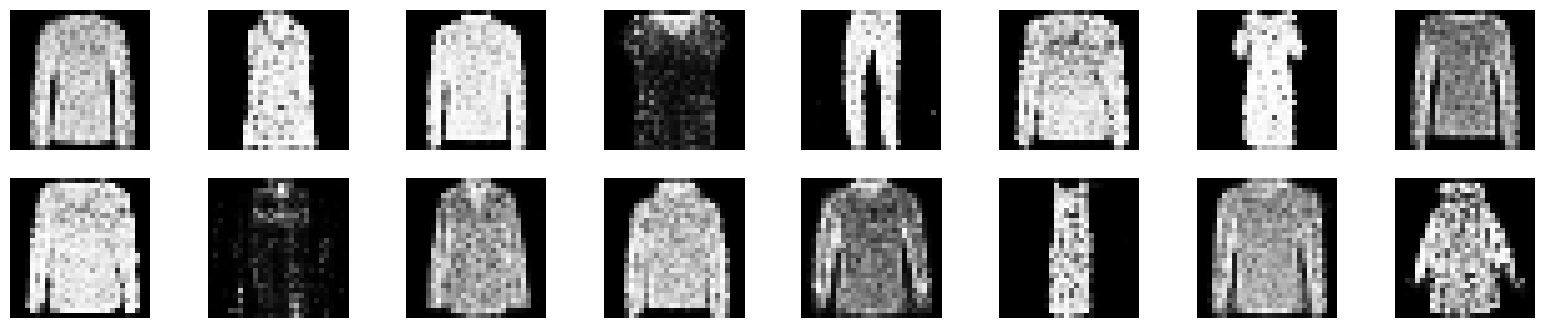

100%|██████████| 1875/1875 [00:11<00:00, 156.69it/s]




Time for epoch 101 is 12.066486358642578 sec
Generator loss: 1.112, Discriminator loss: 0.514


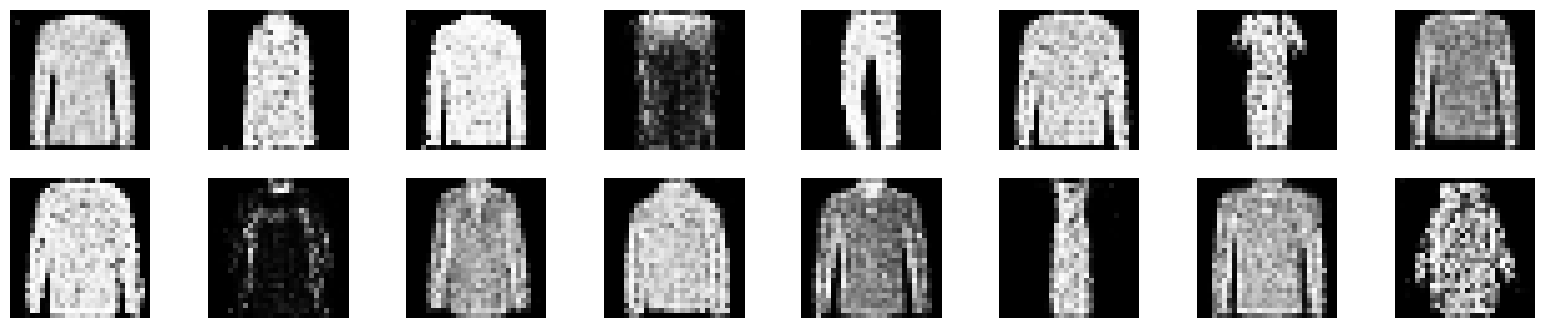

In [72]:
start_training(train_dataloader, epoch_number)

In [74]:
def plot_result(metrics, ylabel = None, ylim = None, metric_name = None, color = None):
    fig, ax = plt.subplots(figsize = (18, 5))
    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, epoch_number - 1])
    plt.ylim(ylim)
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block = False)
    plt.close()

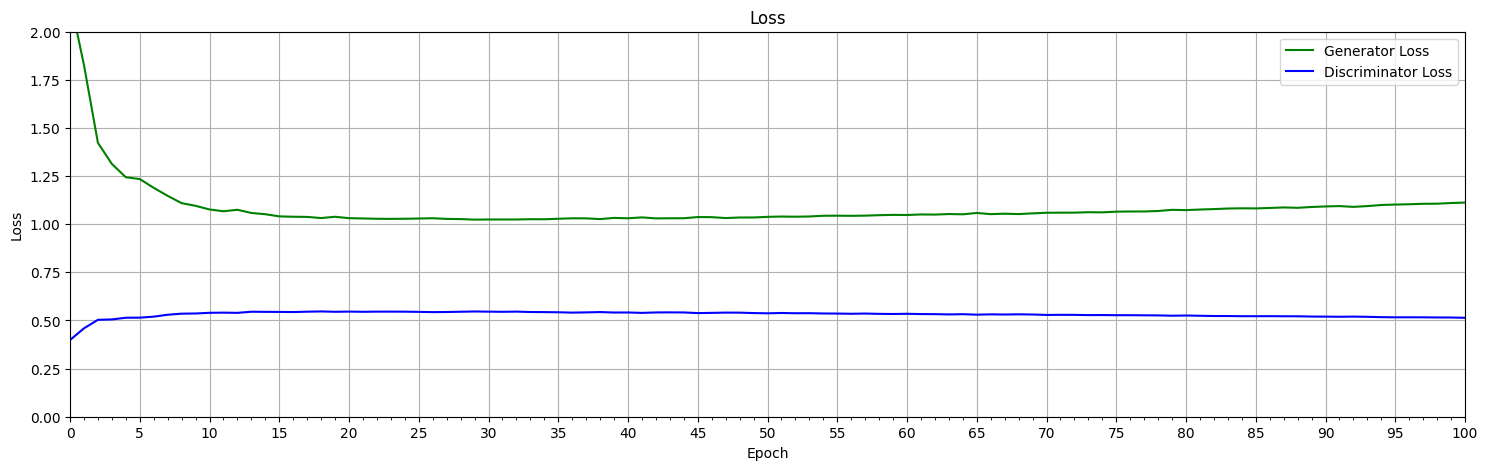

In [75]:
plot_result([generator_loss, discriminator_loss], ylabel = "Loss", ylim = [0, 2],
    metric_name = ["Generator Loss", "Discriminator Loss"], color = ["g", "b"])

In [76]:
trained_generator = torch.load(generator_ckpt)

In [77]:
def generate_images(model, noise):
    model.eval()
    with torch.no_grad():
        images = model(noise.to(device))
        images = images.cpu().view((images.shape[0]), image_height, image_width)

    plt.figure(figsize = (25, 10))
     
    nrow = 4
    ncol = int(noise.shape[0] / nrow)

    for i, image in enumerate(images):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(np.squeeze(image, -1) * 127.5, cmap = 'gray')
        plt.axis('off')  

    plt.show()

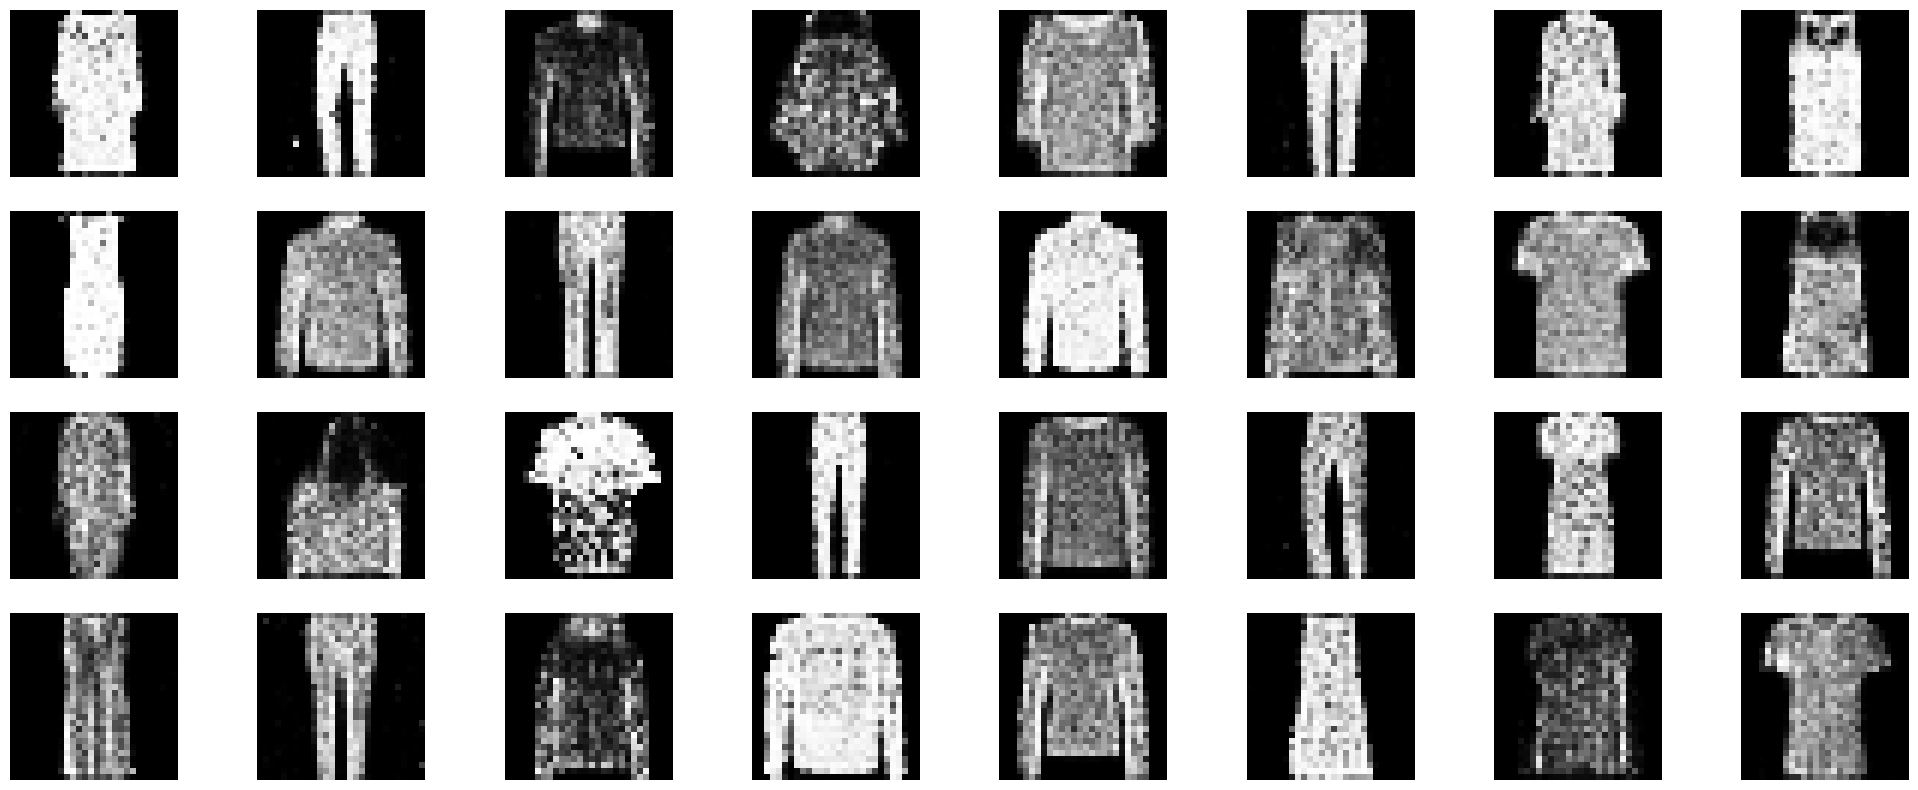

In [80]:
noise = torch.randn(batch_size, latnet_dimension)
generate_images(trained_generator, noise)